In [3]:
#*****************************
%matplotlib inline
!pip install torchxrayvision --quiet
!pip install kaggle --quiet
!pip install captum --quiet
!pip install timm

In [4]:
#***************************'
import sys
import zipfile
import os
import glob
import random
import copy
import shutil
import time
import gc
from IPython.display import Audio, display
import subprocess
import timm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

from collections import Counter
#*************************
import os

import torch

import torch.nn.functional as F
from PIL import Image
from torch.optim import Adam, AdamW

import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

import torchxrayvision as xrv
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torchvision.models as models
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


from sklearn.model_selection import train_test_split
import seaborn as sns
from captum.attr import LayerGradCam

import random





In [5]:
import os
os.getcwd()

'/Project'

In [8]:
#*******************************
# Load and visualize label structure
df_path = "datasets/rsna-pneumonia/stage_2_train_labels.csv"

# Load the CSV into a DataFrame
df_labels = pd.read_csv(df_path)

# Show basic info
print("✅ Labels loaded successfully!")
print(df_labels.head())


✅ Labels loaded successfully!
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [13]:
# Explore dicom-tags included in images and create a dataframe with all data, df_full. the data from labels is also included, 
# note that here there's only one row per patient in df_full, bounding boxes are given as lists

# Path to DICOM files and label CSV
# Paths
dicom_dir = "../../../datasets/rsna-pneumonia/stage_2_train_images"
df_labels_temp = df_labels.copy()

# Function to extract all the available tags you listed
def extract_all_dicom_tags(dicom_path):
    ds = pydicom.dcmread(dicom_path, stop_before_pixels=True)  # No need to load heavy PixelData here
    return {
        'patientId': os.path.splitext(os.path.basename(dicom_path))[0],
        'SpecificCharacterSet': ds.get((0x0008, 0x0005), '').value,
        'SOPClassUID': ds.get((0x0008, 0x0016), '').value,
        'SOPInstanceUID': ds.get((0x0008, 0x0018), '').value,
        'StudyDate': ds.get((0x0008, 0x0020), '').value,
        'StudyTime': ds.get((0x0008, 0x0030), '').value,
        'AccessionNumber': ds.get((0x0008, 0x0050), '').value,
        'Modality': ds.get((0x0008, 0x0060), '').value,
        'ConversionType': ds.get((0x0008, 0x0064), '').value,
        'ReferringPhysiciansName': ds.get((0x0008, 0x0090), '').value,
        'SeriesDescription': ds.get((0x0008, 0x103E), '').value,
        'PatientName': ds.get((0x0010, 0x0010), '').value,
        'PatientID': ds.get((0x0010, 0x0020), '').value,
        'PatientBirthDate': ds.get((0x0010, 0x0030), '').value,
        'PatientSex': ds.get((0x0010, 0x0040), '').value,
        'PatientAge': ds.get((0x0010, 0x1010), '').value,
        'BodyPartExamined': ds.get((0x0018, 0x0015), '').value,
        'ViewPosition': ds.get((0x0018, 0x5101), '').value,
        'StudyInstanceUID': ds.get((0x0020, 0x000D), '').value,
        'SeriesInstanceUID': ds.get((0x0020, 0x000E), '').value,
        'StudyID': ds.get((0x0020, 0x0010), '').value,
        'SeriesNumber': ds.get((0x0020, 0x0011), '').value,
        'InstanceNumber': ds.get((0x0020, 0x0013), '').value,
        'PatientOrientation': ds.get((0x0020, 0x0020), '').value,
        'SamplesPerPixel': ds.get((0x0028, 0x0002), '').value,
        'PhotometricInterpretation': ds.get((0x0028, 0x0004), '').value,
        'Rows': ds.get((0x0028, 0x0010), '').value,
        'Columns': ds.get((0x0028, 0x0011), '').value,
        'PixelSpacing': ds.get((0x0028, 0x0030), '').value,
        'BitsAllocated': ds.get((0x0028, 0x0100), '').value,
        'BitsStored': ds.get((0x0028, 0x0101), '').value,
        'HighBit': ds.get((0x0028, 0x0102), '').value,
        'PixelRepresentation': ds.get((0x0028, 0x0103), '').value,
        'LossyImageCompression': ds.get((0x0028, 0x2110), '').value,
        'LossyImageCompressionMethod': ds.get((0x0028, 0x2114), '').value,
        # PixelData (7FE0,0010) NOT extracted here because it's heavy raw pixel array.
    }

# Read all DICOM metadata
dicom_metadata = []
for fname in os.listdir(dicom_dir):
    if fname.endswith('.dcm'):
        path = os.path.join(dicom_dir, fname)
        try:
            metadata = extract_all_dicom_tags(path)
            dicom_metadata.append(metadata)
        except Exception as e:
            print(f"Error reading {fname}: {e}")

# Create DataFrame from metadata
df_dicom = pd.DataFrame(dicom_metadata)

# Add bounding boxes and targets
df_labels_temp['bbox'] = df_labels_temp[['x', 'y', 'width', 'height']].values.tolist()

df_bboxes = df_labels_temp.groupby('patientId').agg({
    'Target': 'max',         # 0 or 1
    'bbox': list
}).reset_index()

# Merge metadata with labels
df_full = pd.merge(df_dicom, df_bboxes, left_on='patientId', right_on='patientId', how='left')

# Fill missing Targets and bbox lists
df_full['Target'] = df_full['Target'].fillna(0).astype(int)
df_full['bbox'] = df_full['bbox'].apply(lambda x: x if isinstance(x, list) else [])
# convert ages from string to int
df_full['PatientAge'] = pd.to_numeric(df_full['PatientAge'], errors='coerce').astype('Int64')
# Replace empties with NaN
df_full = df_full.replace('', np.nan)


# Done!
df_full.head()

patientId SpecificCharacterSet  \
0  acb5c720-f741-415c-993c-65855be08ffa           ISO_IR 100   
1  7b7709a9-cc53-42f1-ae80-228d31aff18a           ISO_IR 100   
2  39ebb0a8-3fad-42c6-83d1-b92272c32f6f           ISO_IR 100   
3  32e8b837-8656-47e1-87ec-b365c7670984           ISO_IR 100   
4  f86a02d1-4ee2-4578-b001-a03952254643           ISO_IR 100   

                 SOPClassUID  \
0  1.2.840.10008.5.1.4.1.1.7   
1  1.2.840.10008.5.1.4.1.1.7   
2  1.2.840.10008.5.1.4.1.1.7   
3  1.2.840.10008.5.1.4.1.1.7   
4  1.2.840.10008.5.1.4.1.1.7   

                                      SOPInstanceUID StudyDate  StudyTime  \
0  1.2.276.0.7230010.3.1.4.8323329.29831.15178744...  19010101  000000.00   
1  1.2.276.0.7230010.3.1.4.8323329.18638.15178744...  19010101  000000.00   
2  1.2.276.0.7230010.3.1.4.8323329.28978.15178744...  19010101  000000.00   
3  1.2.276.0.7230010.3.1.4.8323329.23262.15178744...  19010101  000000.00   
4  1.2.276.0.7230010.3.1.4.8323329.5069.151787431...  19010101  000000.00   

   AccessionNumber Modality ConversionType  ReferringPhysiciansName  ...  \
0              NaN       CR            WSD                      NaN  ...   
1              NaN       CR            WSD                      NaN  ...   
2              NaN       CR            WSD                      NaN  ...   
3              NaN       CR            WSD                      NaN  ...   
4              NaN       CR            WSD                      NaN  ...   

  Columns                                PixelSpacing BitsAllocated  \
0    1024                              [0.171, 0.171]             8   
1    1024  [0.19431099999999998, 0.19431099999999998]             8   
2    1024                              [0.139, 0.139]             8   
3    1024                              [0.171, 0.171]             8   
4    1024                              [0.139, 0.139]             8   

   BitsStored HighBit  PixelRepresentation LossyImageCompression  \
0           8       7                    0                    01   
1           8       7                    0                    01   
2           8       7                    0                    01   
3           8       7                    0                    01   
4           8       7                    0                    01   

  LossyImageCompressionMethod Target  \
0                 ISO_10918_1      1   
1                 ISO_10918_1      0   
2                 ISO_10918_1      0   
3                 ISO_10918_1      1   
4                 ISO_10918_1      1   

                                                bbox  
0  [[187.0, 384.0, 249.0, 141.0], [576.0, 237.0, ...  
1                             [[nan, nan, nan, nan]]  
2                             [[nan, nan, nan, nan]]  
3                     [[236.0, 534.0, 171.0, 115.0]]  
4  [[666.0, 515.0, 146.0, 264.0], [175.0, 417.0, ...  

[5 rows x 37 columns]

In [ ]:
# Save df_full to csv
df_full.to_csv('df_full.csv')

In [13]:
# If df_full is already saved, load it
df_full = pd.read_csv('datasets/rsna-pneumonia/masks/df_full.csv')

In [14]:
#create df_labels2 with PatientSex and ViewPosition
df_labels2 = df_labels.copy()
# pick only needed columns from df_full
meta = df_full[['patientId','PatientSex','ViewPosition']]

# merge them into df_labels2
df_labels2 = df_labels.merge(meta, on='patientId', how='left')
df_labels2.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'PatientSex',
       'ViewPosition'],
      dtype='object')

In [15]:
# This list was produced previously through lung segmentation and selection of images with very small lung masks indicating 
# poor image quality

#*********************''
excl_lst = ['809830cd-c757-4e81-abec-0d6d935ae0ce', 'ba221090-4382-4ccf-afc2-cda9af445aa5', '6438d645-6fdb-4fda-8598-a4c1902a33c2', 'b35d57ee-f22b-4c8c-b959-3ee8eecef555', 'f0486970-9fc3-469e-9b80-375b5a04f9ae', '01fa0f5e-00c3-41cb-b5c7-10600c8633ae', 'bc668e08-44be-4aed-aa17-7b321c8e11a5', 'b08e4c8f-0dbf-4878-90f6-82220205f8a1', 'c5371ee3-958d-40de-8359-13c58e0bc071', '4c7afe96-9f99-496f-a4c4-d27a3d76a767', '70d7f4df-5497-4205-a36b-e47b58145fa2', 'b957974c-211b-4f52-86d3-25d18825dfa3', '5e3da45b-f7b6-4948-aad4-7a37cf9cae5b', '335d17b1-bdfb-4939-9dc9-fa93f09648eb', 'bd7b6626-82a0-4410-b96b-3109223128e1', '949d29ea-c8d1-4627-aa46-65aca7112946', '3874e3f6-0c79-4fc1-a874-1d761e475e53', '75431238-8d46-4b70-bbb7-128bd58602cd', '74ef566d-21ce-4b66-b134-a713ca915762', 'f418c86c-13cb-44a4-b090-21030f9fc95e', 'c241425c-418c-4958-8a18-c3425fe03f03', '09bfe52b-201a-435a-b04f-ada40a64b5b5', 'ecb0e8b7-0f0f-40ed-848d-8b070a14bc8c', '66bcb6f8-946f-4f66-8d18-06f17b01d3cd', 'f22a216f-9194-49be-ae18-1c2b09b86de9', '13990031-9dbf-4e03-9505-0f9120bdb166', '3fad6559-5289-4da1-a682-df0c97a08e38', '8af89b60-74e2-4f60-8764-b954598cddc4', '35621d68-0915-463c-b0f8-2365c6e56e11', '4068843a-d393-45cb-9d08-567238cdc6d2', '28b67d93-2432-41e4-9e3b-3d0ba249ad39']

excl_lst.append('fcd6452c-680d-40a6-9fc6-1793eb3ca0a8')
print(excl_lst)

['809830cd-c757-4e81-abec-0d6d935ae0ce', 'ba221090-4382-4ccf-afc2-cda9af445aa5', '6438d645-6fdb-4fda-8598-a4c1902a33c2', 'b35d57ee-f22b-4c8c-b959-3ee8eecef555', 'f0486970-9fc3-469e-9b80-375b5a04f9ae', '01fa0f5e-00c3-41cb-b5c7-10600c8633ae', 'bc668e08-44be-4aed-aa17-7b321c8e11a5', 'b08e4c8f-0dbf-4878-90f6-82220205f8a1', 'c5371ee3-958d-40de-8359-13c58e0bc071', '4c7afe96-9f99-496f-a4c4-d27a3d76a767', '70d7f4df-5497-4205-a36b-e47b58145fa2', 'b957974c-211b-4f52-86d3-25d18825dfa3', '5e3da45b-f7b6-4948-aad4-7a37cf9cae5b', '335d17b1-bdfb-4939-9dc9-fa93f09648eb', 'bd7b6626-82a0-4410-b96b-3109223128e1', '949d29ea-c8d1-4627-aa46-65aca7112946', '3874e3f6-0c79-4fc1-a874-1d761e475e53', '75431238-8d46-4b70-bbb7-128bd58602cd', '74ef566d-21ce-4b66-b134-a713ca915762', 'f418c86c-13cb-44a4-b090-21030f9fc95e', 'c241425c-418c-4958-8a18-c3425fe03f03', '09bfe52b-201a-435a-b04f-ada40a64b5b5', 'ecb0e8b7-0f0f-40ed-848d-8b070a14bc8c', '66bcb6f8-946f-4f66-8d18-06f17b01d3cd', 'f22a216f-9194-49be-ae18-1c2b09b86de9',

In [16]:
# Loss functions instantiation

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = "mean"):
        """
        alpha: balance parameter in [0,1] for the positive class
        gamma: focusing parameter ≥ 0
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        logits: raw model outputs (N, ...)   — no sigmoid applied yet
        targets: same shape, {0,1} float
        """
        # BCE with logits gives us: CE = -[y*logσ + (1-y)*log(1-σ)]
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probs = torch.sigmoid(logits)

        # p_t = prob of the true class
        p_t = probs * targets + (1 - probs) * (1 - targets)

        # focal term: (1 - p_t)^γ
        focal_factor = (1 - p_t).pow(self.gamma)

        # alpha weighting term
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        loss = alpha_factor * focal_factor * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # "none"

class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1e-6):
        """
        Dice loss for binary segmentation.
        smooth: smoothing factor to avoid division by zero.
        """
        super().__init__()
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        logits: (N, H, W) raw output for the positive class
        targets: (N, H, W) binary ground truth {0,1}
        """
        probs = torch.sigmoid(logits)
        # flatten
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)
        # intersection and sums
        intersection = (probs_flat * targets_flat).sum(dim=1)
        union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        # dice loss = 1 - dice coefficient
        return 1 - dice.mean()



class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = p*targets + (1-p)*(1-targets)
        loss = ce * ((1-p_t)**self.gamma)
        alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
        return (alpha_t * loss).mean()


In [17]:
# support function for training to get shifting weights for different losses during trainning
#***************************
def compute_weights(epoch, T, 
                    alpha_start, beta_start, gamma_start, 
                    alpha_end, beta_end, gamma_end):
    """
    Linearly interpolate weights from start to end over T epochs,
    then normalize so that alpha+beta+gamma = 1.
    """
    t = min(epoch / T, 1.0)
    # Linear interpolation
    alpha = alpha_start * (1 - t) + alpha_end * t
    beta  = beta_start  * (1 - t) + beta_end  * t
    gamma = gamma_start * (1 - t) + gamma_end * t
    
    # Normalize to sum=1
    total = alpha + beta + gamma
    alpha /= total
    beta  /= total
    gamma /= total
    
    return alpha, beta, gamma

In [18]:
# Dataset for the data that contain image, bounding box-mask, gender and view position
class PneumoniaDataset3(Dataset):
    def __init__(self,
        labels_df,
        images_dir,
        lung_mask_dir="/kaggle/input/rsna-pneumonia-lung-masks",
        bbox_mask_dir="/kaggle/input/bbox-masks",
        transform=None, 
        augment = True, 
        max_rotate = 10, 
        max_translate = 0.1, 
        max_contrast = 0.1
        
        ):
        self.labels_df = labels_df
        self.images_dir = images_dir
        self.lung_mask_dir = lung_mask_dir
        self.bbox_mask_dir = bbox_mask_dir
        self.max_rotate = max_rotate
        self.max_translate = max_translate
        self.max_contrast = max_contrast
        self.augment = augment
        # Default transform: resize to 512×512, to tensor (1 channel)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()  # yields (1, H, W)
            ])
        else:
            self.transform = transform
         # Unique list of patient IDs
        self.patients = self.labels_df["patientId"].unique()
    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        pid = self.patients[idx]
                # --- 1) Load & normalize DICOM directly to tensor ---
        import pydicom
        
        ds = pydicom.dcmread(os.path.join(self.images_dir, f"{pid}.dcm"))
        arr = ds.pixel_array.astype(np.float32)
        
        # — apply RescaleSlope / RescaleIntercept if present —
        slope = float(getattr(ds, 'RescaleSlope', 1.0))
        intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
        arr = arr * slope + intercept
        
        # — invert if MONOCHROME1 (DICOM might store “0=white” images) —
        if getattr(ds, 'PhotometricInterpretation', '') == 'MONOCHROME1':
            arr = arr.max() - arr
        
        # — now MIN–MAX normalize to [0,1] per image —
        arr -= arr.min()
        arr /= (arr.max() - arr.min() + 1e-8)
        
        img_t = torch.from_numpy(arr).unsqueeze(0)  # shape (1, H, W)
                
        # --- 2) Apply center crop + resize on tensor ---
        #   torchvision transforms allow tensor inputs:
        img_t = TF.center_crop(img_t, (min(arr.shape), min(arr.shape)))
        img_t = TF.resize(img_t, [512, 512])
       

        # Load lung mask (.npz → array)
        lung_path = os.path.join(self.lung_mask_dir, f"{pid}_lung_mask.npz")
        if os.path.exists(lung_path):
            npz = np.load(lung_path)
            lung_arr = npz[npz.files[0]]
        else:
            lung_arr = np.zeros((512, 512), dtype=np.uint8)
        lung_mask = torch.from_numpy(lung_arr).float().unsqueeze(0)  # (1, 512, 512)

        # Load bbox mask (.npz → array)
        bbox_path = os.path.join(self.bbox_mask_dir, f"{pid}_bbox_mask.npz")
        if os.path.exists(bbox_path):
            npz_b = np.load(bbox_path)
            bbox_arr = npz_b[npz_b.files[0]]
        else:
            bbox_arr = np.zeros((512, 512), dtype=np.uint8)
        bbox_mask = torch.from_numpy(bbox_arr).float().unsqueeze(0)  # (1, 512, 512)

        # Ensure mask size matches image
        if lung_mask.shape[1:] != img_t.shape[1:]:
            lung_mask = F.interpolate(lung_mask.unsqueeze(0),
                                      size=img_t.shape[1:], mode='nearest').squeeze(0)
        if bbox_mask.shape[1:] != img_t.shape[1:]:
            bbox_mask = F.interpolate(bbox_mask.unsqueeze(0),
                                      size=img_t.shape[1:], mode='nearest').squeeze(0)
            
       
       
        
        if self.augment:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            max_dx = int(self.max_translate * img_t.shape[-1])
            max_dy = int(self.max_translate * img_t.shape[-2])
            translate = (random.randint(-max_dx, max_dx),
                         random.randint(-max_dy, max_dy))
        
            img_t      = TF.affine(img_t,      angle, translate, 1.0, 0.0,
                                    interpolation=InterpolationMode.BILINEAR, fill=0)
            lung_mask  = TF.affine(lung_mask,  angle, translate, 1.0, 0.0,
                                    interpolation=InterpolationMode.NEAREST, fill=0)
            bbox_mask  = TF.affine(bbox_mask,  angle, translate, 1.0, 0.0,
                                    interpolation=InterpolationMode.NEAREST, fill=0)
        
            # contrast, brightness, gamma
            cf = random.uniform(1 - self.max_contrast, 1 + self.max_contrast)
            bf = random.uniform(0.8, 1.2)
            gm = random.uniform(0.7, 1.3)
        
            img_t = TF.adjust_contrast(  img_t, cf)
            img_t = torch.clamp(img_t, 0.0, 1.0)
            img_t = TF.adjust_brightness(img_t, bf)
            img_t = torch.clamp(img_t, 0.0, 1.0)
            img_t = TF.adjust_gamma(     img_t, gamma=gm, gain=1.0)
                
            img_t = torch.clamp(img_t, 0.0, 1.0)
                    

        # Combine masks: channel 0=lung, channel 1=bbox
        mask = torch.cat([lung_mask, bbox_mask], dim=0)  # (2, 512, 512)

        
        # 4) Get global pneumonia label
        lbl = self.labels_df.loc[self.labels_df["patientId"] == pid, "Target"].max()
        label = torch.tensor(float(lbl), dtype=torch.float32)

        # 5) Pull out metadata and binarize
        row = self.labels_df.loc[self.labels_df["patientId"] == pid].iloc[0]
        # example mapping—adjust if your codes differ
        gender = 1.0 if row["PatientSex"] == "F" else 0.0
        viewpos = 1.0 if row["ViewPosition"] == "AP" else 0.0
        gender = torch.tensor(gender, dtype=torch.float32)
        viewpos = torch.tensor(viewpos, dtype=torch.float32)

        # 6) stack masks and repeat image to 3 channels
        mask = torch.cat([lung_mask, bbox_mask], dim=0)  # (2,512,512)
        img_t = img_t.repeat(3,1,1)                     # (3,512,512)

        return img_t, mask, label, gender, viewpos

In [20]:
# Create loaders.

IMAGES_DIR    = "datasets/rsna-pneumonia/stage_2_train_images"
LUNG_MASK_DIR = "datasets/rsna-pneumonia/masks/lung_masks_npz"
BBOX_MASK_DIR = "datasets/rsna-pneumonia/masks/bbox_masks_npz"

# Read labels and extract unique patient IDs
labels_df2 = df_labels2.copy()

# Test to see if excl_lst is defined, otherwise instatiate as empty list then exclude the IDs in it from patients
try:
    excl_lst
except NameError:
    excl_lst = []
filtered_df = labels_df2[~labels_df2["patientId"].isin(excl_lst)].copy()
patients  = filtered_df["patientId"].unique()

# Split: 90% train, 7.5% val, 2.5% test
train_ids2, temp_ids2 = train_test_split(patients, test_size=0.1, random_state=42)
val_ids2,   test_ids2 = train_test_split(temp_ids2, test_size=0.25, random_state=42)

# Create DataFrames for each split
train_df2 = labels_df2[labels_df2["patientId"].isin(train_ids2)].reset_index(drop=True)
val_df2   = labels_df2[labels_df2["patientId"].isin(val_ids2)].reset_index(drop=True)
test_df2  = labels_df2[labels_df2["patientId"].isin(test_ids2)].reset_index(drop=True)

print(f"Data splits — Train: {len(train_ids2)}, Val: {len(val_ids2)}, Test: {len(test_ids2)}")

# Instantiate your datasets (requires PneumoniaDataset3 defined earlier)
train_ds2 = PneumoniaDataset3(train_df2, IMAGES_DIR, lung_mask_dir=LUNG_MASK_DIR, bbox_mask_dir=BBOX_MASK_DIR)
val_ds2   = PneumoniaDataset3(val_df2,   IMAGES_DIR, lung_mask_dir=LUNG_MASK_DIR, bbox_mask_dir=BBOX_MASK_DIR, augment = False)
test_ds2  = PneumoniaDataset3(test_df2,  IMAGES_DIR, lung_mask_dir=LUNG_MASK_DIR, bbox_mask_dir=BBOX_MASK_DIR, augment = False)

# Extract the patient‐level labels in the same order your dataset will:
#    For each pid in train_ds.patients, find its max Target (0 or 1). Shouldn't be a problem but as a precaution.
patient_ids2 = train_ds2.patients  # array of unique patientIds
patient_labels2 = [
    train_df2.loc[train_df2.patientId == pid, "Target"].max()
    for pid in patient_ids2
]                                     

# Compute class counts & inverse weights
import numpy as np
targets_arr2   = np.array(patient_labels2, dtype=int)    
class_counts2  = np.bincount(targets_arr2)               
class_weights2 = 1.0 / class_counts2                      

# Build per‐patient weights array and convert to tensor
weights_np2   = class_weights2[targets_arr2]               
weights_tensor2 = torch.from_numpy(weights_np2).double()  

# Create sampler with exactly len(train_ds) samples
sampler2 = WeightedRandomSampler(
    weights=weights_tensor2,
    num_samples=len(train_ds2),    
    replacement=True
)

# Wrap in DataLoaders
train_loader2 = DataLoader(train_ds2, batch_size=8, sampler = sampler2, num_workers=4)
val_loader2   = DataLoader(val_ds2,   batch_size=8, shuffle=False, num_workers=4)
test_loader2  = DataLoader(test_ds2,  batch_size=8, shuffle=False, num_workers=4)

# Quick shape check
imgs, masks, labels, _,_ = next(iter(train_loader2))
print("imgs:  ", imgs.shape)   # -> (8, 3, 512, 512)
print("masks: ", masks.shape)  # -> (8, 2, 512, 512)
print("labels:", labels.shape) # -> (8,)

Data splits — Train: 23986, Val: 1999, Test: 667
imgs:   torch.Size([8, 3, 512, 512])
masks:  torch.Size([8, 2, 512, 512])
labels: torch.Size([8])


In [21]:
# Network with 
class BBoxAndClassifierModel_pat2(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = timm.create_model('seresnet50', pretrained=True)
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])  # → (N,2048,H/32,W/32)

        # FiLM generator: maps 2-dim metadata → 2048 attention logits
        self.film_gen = nn.Sequential(
                nn.Linear(2, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 2048)
                )
        
        # Optional: initialize gamma logits to something neutral
        nn.init.constant_(self.film_gen[-1].bias, 0.0)  # logits = 0 → softmax = uniform

        # segmentation head (unchanged)
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 256, 1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, padding=1),  nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1),   nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 2, 1)
        )

        # classification head (unchanged)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x, gender, viewpos):
        # 1) Encode
        feats = self.encoder(x)                # (N,2048,H',W')
        N = feats.size(0)
        
        # 2) Pack metadata
        meta = torch.stack([gender.float(), viewpos.float()], dim=1)  # (N,2)
        
        # 3) Compute FiLM attention
        logits = self.film_gen(meta)           # (N, 2048)
        attn   = torch.softmax(logits, dim=1)  # (N, 2048), sums to 1 per sample, trying to counteract metadata bias
        gamma  = attn.view(N, 2048, 1, 1) * 2048
         
        
        # 4) Modulate features
        feats_mod = feats * gamma      # (N,2048,H',W')
        
        # 5) Heads
        seg_out   = self.decoder(feats_mod)     # (N,2,512,512)
        cls_logit = self.classifier(feats_mod)  # (N,1) before squeeze
        cls_logit = cls_logit.squeeze(1)        # (N,)
        
        return seg_out, cls_logit



In [47]:
# 1) Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = BBoxAndClassifierModel_pat2().to(device)
print(device)

cuda


Start training


Training:   0%|          | 0/2999 [00:00<?, ?it/s]

Epoch 1/5 — Training Loss: 0.8751


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

 Best val model saved at epoch 1


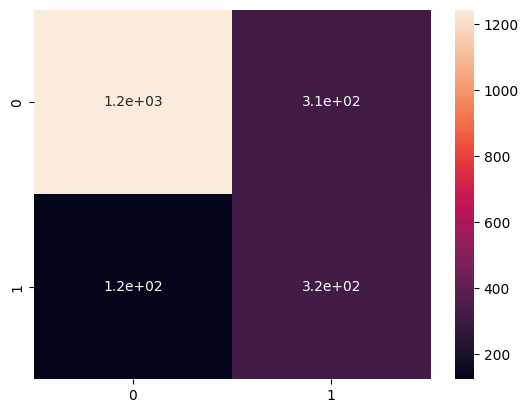

Epoch 1/5 — Validation Loss: 0.4633
Validation: BBox loss: 0.9812,  Label loss: 0.4633
  Validation Accuracy: 0.7824


Training:   0%|          | 0/2999 [00:00<?, ?it/s]

Epoch 2/5 — Training Loss: 0.8074


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

 Best val model saved at epoch 2


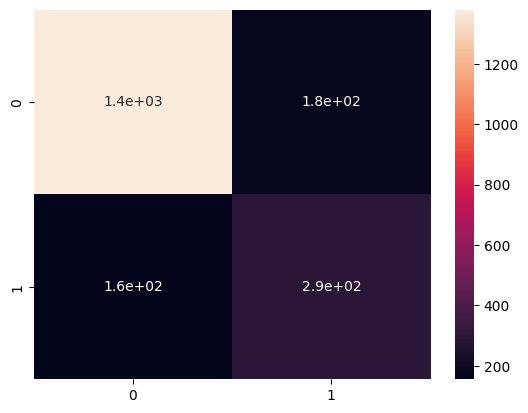

Epoch 2/5 — Validation Loss: 0.3890
Validation: BBox loss: 0.9758,  Label loss: 0.3890
  Validation Accuracy: 0.8344


Training:   0%|          | 0/2999 [00:00<?, ?it/s]

Epoch 3/5 — Training Loss: 0.7813


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/5 — Validation Loss: 0.3974
Validation: BBox loss: 0.9725,  Label loss: 0.3974
  Validation Accuracy: 0.8239


Training:   0%|          | 0/2999 [00:00<?, ?it/s]

Epoch 4/5 — Training Loss: 0.7687


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

 Best val model saved at epoch 4


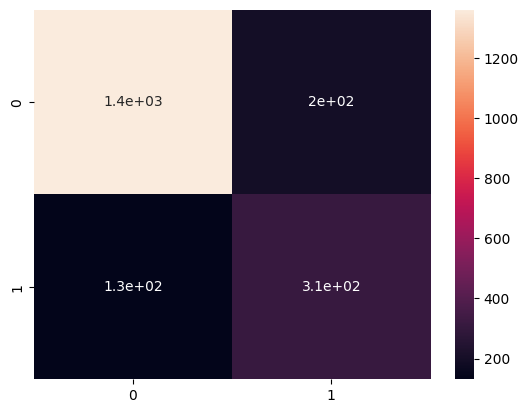

Epoch 4/5 — Validation Loss: 0.3705
Validation: BBox loss: 0.9615,  Label loss: 0.3705
  Validation Accuracy: 0.8369


Training:   0%|          | 0/2999 [00:00<?, ?it/s]

Epoch 5/5 — Training Loss: 0.7506


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/5 — Validation Loss: 0.3889
Validation: BBox loss: 0.9626,  Label loss: 0.3889
  Validation Accuracy: 0.8244


In [48]:
#number 2
from torch.optim.lr_scheduler import CosineAnnealingLR

print('Start training', flush = True)
patience = 8
pat_ind = 0 # Patience index, how many epochs without improvement
# Loss and optimizer
# Initiate loss functions
seg_criterion = nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()
lbl_criterion = BinaryFocalLoss(alpha=0.5, gamma=0)

optimizer = AdamW([
    {'params': model3.encoder.parameters(),   'lr':1e-5, 'weight_decay':1e-4},
    {'params': model3.decoder.parameters(),   'lr':1e-4, 'weight_decay':1e-4},
    {'params': model3.film_gen.parameters(),  'lr':1e-4, 'weight_decay':0   },
    {'params': model3.classifier.parameters(),'lr':1e-4, 'weight_decay':0   },
])

scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

num_epochs     = 5
best_val_loss  = 100 # Arbitrary high starting value
best_model     = None
# Initiate dictionary for storing losses for plotting
loss_dict = {}
loss_dict['val_bbox_loss']=[]
loss_dict['val_label_loss']=[]
loss_dict['val_loss'] = []
loss_dict['val_acc'] = []
loss_dict['train_loss']=[]
loss_dict['train_label_loss']=[]
loss_dict['train_bbox_loss']=[]

for epoch in range(num_epochs):
    # 2) Compute normalized weights for this epoch
    alpha, beta, gamma = compute_weights(
        epoch,                 # current epoch
        T= 15,         # or your warmup length
        alpha_start=0, beta_start=0.9, gamma_start=0.1,
        alpha_end=0,   beta_end=0.7,   gamma_end=0.3
    )
 
    # ---- Training ----
    model3.train()
    running_loss = 0.0
    
    for imgs, masks, labels, gender, viewpos in tqdm(train_loader2, desc='Training'):
        imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)

        # Forward
        seg_out, label_pred = model3(imgs,gender, viewpos)
        
        # Bounding box prediction and ground truth       
        box_pred  = seg_out[:, 1, :, :]        # (N,H,W)
        box_gt    = masks[:, 1, :, :]

        # Losses        
        loss_box   = seg_criterion(box_pred,  box_gt) + dice_loss_fn(box_pred, box_gt)
        loss_label = lbl_criterion(label_pred.squeeze(-1), labels)
        # Combine losses to training loss
        loss =  beta * loss_box + gamma * loss_label
        # Save losses for plotting
        loss_dict['train_bbox_loss'].append(loss_box)
        loss_dict['train_label_loss'].append(loss_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader2)
    print(f"Epoch {epoch+1}/{num_epochs} — Training Loss: {avg_train_loss:.4f}")
    
    loss_dict['train_loss'].append(avg_train_loss)
    # ---- Validation ----
    model3.eval()
    val_loss        = 0.0
    bbox_l, label_l = 0.0, 0.0
    correct_labels  = 0
    total_labels    = 0

    with torch.no_grad():
        all_trues = []
        all_preds = []

        for imgs, masks, labels, gender, viewpos in tqdm(val_loader2, desc='Validation'):
            imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)

            seg_out, label_pred = model3(imgs, gender, viewpos)
            # Extract bounding box prediction and ground truth
            box_pred  = seg_out[:, 1, :, :]
            box_gt    = masks[:, 1, :, :]
            #Calculate batch loss
            loss_box = seg_criterion(box_pred,  box_gt) + dice_loss_fn(box_pred, box_gt)
            loss_label = seg_criterion(label_pred.squeeze(-1), labels)
            #Accumulate losses per batch
            val_loss += loss_label
            bbox_l   += loss_box
            label_l  += loss_label

            # accuracy
            probs = torch.sigmoid(label_pred.squeeze(-1))
            preds = (probs >= 0.5).float()
            correct_labels += (preds == labels).sum().item()
            total_labels   += labels.size(0)

            all_trues.extend(labels.to('cpu').tolist())
            all_preds.extend(preds.to('cpu').tolist())
            
    avg_val_loss = val_loss  / len(val_loader2)
    avg_bbox_l   = bbox_l    / len(val_loader2)
    avg_label_l  = label_l   / len(val_loader2)
    val_acc      = correct_labels / total_labels
    # save losses for plotting
    loss_dict['val_acc'].append(val_acc)
    loss_dict['val_bbox_loss'].append(avg_bbox_l)
    loss_dict['val_label_loss'].append(avg_label_l)
    loss_dict['val_loss'].append(avg_val_loss)
    loss_dict['val_acc'].append(val_acc)
    
    # save best model state
    if best_val_loss is None or avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model    = copy.deepcopy(model3.state_dict())
        pat_ind = 0
        print(f' Best val model saved at epoch {epoch+1}', flush = True)
        cf_matrix = confusion_matrix(all_trues, all_preds)
        sns.heatmap(cf_matrix, annot=True)
        plt.show()
    else:
        pat_ind +=1
    
    print(f"Epoch {epoch+1}/{num_epochs} — Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation: BBox loss: {avg_bbox_l:.4f},  Label loss: {avg_label_l:.4f}")
    
    print(f"  Validation Accuracy: {val_acc:.4f}")
    if pat_ind > patience:
        break
    scheduler.step()
   
# After all epochs, save best model
torch.save(best_model, 'best_val_model.pt')




In [57]:
model3.load_state_dict(torch.load('best_val_model.pt'))

<All keys matched successfully>

In [ ]:
#number 2
from torch.optim.lr_scheduler import CosineAnnealingLR

print('Start training', flush = True)
patience = 8
pat_ind = 0 # Patience index, how many epochs without improvement
# Loss and optimizer
# Initiate loss functions
seg_criterion = nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()
lbl_criterion = BinaryFocalLoss(alpha=0.6, gamma=0)
optimizer = AdamW([
    {'params': model3.encoder.parameters(),   'lr':1e-5, 'weight_decay':1e-5},
    {'params': model3.decoder.parameters(),   'lr':1e-5, 'weight_decay':1e-5},
    {'params': model3.film_gen.parameters(),  'lr':1e-5, 'weight_decay':0   },
    {'params': model3.classifier.parameters(),'lr':1e-5, 'weight_decay':0   },
])

scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

num_epochs     = 5
best_val_loss  = best_val_loss # From previous training

# Initiate dictionary for storing losses for plotting
loss_dict = {}
loss_dict['val_bbox_loss']=[]
loss_dict['val_label_loss']=[]
loss_dict['val_loss'] = []
loss_dict['val_acc'] = []
loss_dict['train_loss']=[]
loss_dict['train_label_loss']=[]
loss_dict['train_bbox_loss']=[]

for epoch in range(num_epochs):
    # 2) Compute normalized weights for this epoch
    alpha, beta, gamma = 0,0.7,0.3
    '''
    compute_weights(
        epoch,                 # current epoch
        T= 15,         # or your warmup length
        alpha_start=0, beta_start=0.9, gamma_start=0.1,
        alpha_end=0,   beta_end=0.7,   gamma_end=0.3
    )
    '''
    # ---- Training ----
    model3.train()
    running_loss = 0.0
    
    for imgs, masks, labels, gender, viewpos in tqdm(train_loader2, desc='Training'):
        imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)

        # Forward
        seg_out, label_pred = model3(imgs,gender, viewpos)
        
        # Bounding box prediction and ground truth       
        box_pred  = seg_out[:, 1, :, :]        # (N,H,W)
        box_gt    = masks[:, 1, :, :]

        # Losses        
        loss_box   = seg_criterion(box_pred,  box_gt) + dice_loss_fn(box_pred, box_gt)
        loss_label = lbl_criterion(label_pred.squeeze(-1), labels)
        # Combine losses to training loss
        loss =  beta * loss_box + gamma * loss_label
        # Save losses for plotting
        loss_dict['train_bbox_loss'].append(loss_box)
        loss_dict['train_label_loss'].append(loss_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader2)
    print(f"Epoch {epoch+1}/{num_epochs} — Training Loss: {avg_train_loss:.4f}")
    
    loss_dict['train_loss'].append(avg_train_loss)
    # ---- Validation ----
    model3.eval()
    val_loss        = 0.0
    bbox_l, label_l = 0.0, 0.0
    correct_labels  = 0
    total_labels    = 0

    with torch.no_grad():
        all_trues = []
        all_preds = []

        for imgs, masks, labels, gender, viewpos in tqdm(val_loader2, desc='Validation'):
            imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)

            seg_out, label_pred = model3(imgs, gender, viewpos)
            # Extract bounding box prediction and ground truth
            box_pred  = seg_out[:, 1, :, :]
            box_gt    = masks[:, 1, :, :]
            #Calculate batch loss
            loss_box = seg_criterion(box_pred,  box_gt) + dice_loss_fn(box_pred, box_gt)
            loss_label = seg_criterion(label_pred.squeeze(-1), labels)
            #Accumulate losses per batch
            val_loss += loss_label
            bbox_l   += loss_box
            label_l  += loss_label

            # accuracy
            probs = torch.sigmoid(label_pred.squeeze(-1))
            preds = (probs >= 0.5).float()
            correct_labels += (preds == labels).sum().item()
            total_labels   += labels.size(0)

            all_trues.extend(labels.to('cpu').tolist())
            all_preds.extend(preds.to('cpu').tolist())
            
    avg_val_loss = val_loss  / len(val_loader2)
    avg_bbox_l   = bbox_l    / len(val_loader2)
    avg_label_l  = label_l   / len(val_loader2)
    val_acc      = correct_labels / total_labels
    # save losses for plotting
    loss_dict['val_acc'].append(val_acc)
    loss_dict['val_bbox_loss'].append(avg_bbox_l)
    loss_dict['val_label_loss'].append(avg_label_l)
    loss_dict['val_loss'].append(avg_val_loss)
    loss_dict['val_acc'].append(val_acc)
    
    # save best model state
    if best_val_loss is None or avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model    = copy.deepcopy(model3.state_dict())
        pat_ind = 0
        print(f' Best val model saved at epoch {epoch+1}', flush = True)
        cf_matrix = confusion_matrix(all_trues, all_preds)
        sns.heatmap(cf_matrix, annot=True)
        plt.show()
    else:
        pat_ind +=1
    
    print(f"Epoch {epoch+1}/{num_epochs} — Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation: BBox loss: {avg_bbox_l:.4f},  Label loss: {avg_label_l:.4f}")
    
    print(f"  Validation Accuracy: {val_acc:.4f}")
    if pat_ind > patience:
        break
    scheduler.step()
   
# After all epochs, save best model
torch.save(best_model, 'best_val_model.pt')



Start training


Training:   0%|          | 0/2999 [00:00<?, ?it/s]

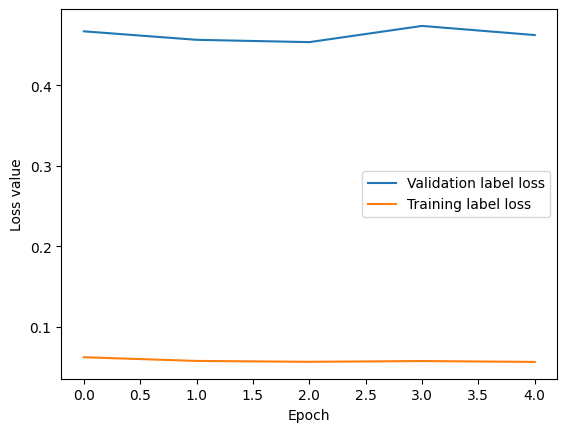

In [58]:
# Plot training and validation loss per epoch
# number of trained epochs
n_epochs = 5

test = loss_dict['val_label_loss'].copy()
test1 = [x.cpu().numpy() for x in test]
test2 = loss_dict['train_label_loss'].copy()
test3 = [x.detach().cpu().numpy() for x in test2]

test4 = []

for i in range(30):
    sublist = test3[i*2999:(i+1)*2999].copy()
    test4.append(sum(sublist)/2999)
    
fig, ax = plt.subplots()
ax.plot(test1[0:n_epochs], label = 'Validation label loss')
ax.plot(test4[0:n_epochs], label = 'Training label loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss value')
ax.legend()

plt.show()

In [59]:
# A function that visualizes two random examples, one with and one without pneumonia with class probability, predicted 
# bounding box mask and true bounding box mask

def visualize_sample_pair3(model, data_loader, device):
    """
    Display one 'sick' and one 'healthy' sample:
      columns: [X-ray, Pred BBox, True BBox]
      rows:    [Sick, Healthy]
    """
    model.eval()
    rand_batch = random.randint(0, len(data_loader))
    # 1) Find the first batch that has at least one sick and one healthy
    batch_idx = None
    for bi, batch in enumerate(data_loader):
        if bi < rand_batch:
            continue
        else:
            imgs, masks, labels, gender, viewpos = batch
            if (labels == 0).any() and (labels == 1).any():
                batch_idx = bi
                break
            if batch_idx is None:
                raise RuntimeError("No batch with both classes found.")
    
    # Move that batch to device
    imgs      = imgs.to(device)       # (B,3,H,W)
    masks     = masks.to(device)      # (B,2,H,W)
    labels    = labels.to(device)     # (B,)
    gender    = gender.to(device)     # (B,)
    viewpos   = viewpos.to(device)    # (B,)

    B = imgs.size(0)
    # 2) Shuffle within‐batch indices and pick one sick + one healthy
    idxs = list(range(B))
    random.shuffle(idxs)
    sick_idx = healthy_idx = None
    for i in idxs:
        if labels[i] == 1 and sick_idx is None:
            sick_idx = i
        if labels[i] == 0 and healthy_idx is None:
            healthy_idx = i
        if sick_idx is not None and healthy_idx is not None:
            break

    # 3) Slice out the two examples
    sel_imgs      = torch.stack([imgs[sick_idx],      imgs[healthy_idx]],      dim=0)
    sel_masks     = torch.stack([masks[sick_idx],     masks[healthy_idx]],     dim=0)
    sel_gender    = torch.stack([gender[sick_idx],    gender[healthy_idx]],    dim=0)
    sel_viewpos   = torch.stack([viewpos[sick_idx],   viewpos[healthy_idx]],   dim=0)
    sel_labels    = torch.stack([labels[sick_idx],    labels[healthy_idx]],    dim=0)

    # 4) Run through the model
    with torch.no_grad():
        seg_out, label_logits = model(sel_imgs, sel_gender, sel_viewpos)
        box_pred    = torch.sigmoid(seg_out[:,1])     # (2,H,W)
        label_prob  = torch.sigmoid(label_logits)     # (2,)

    # 5) Move to CPU/numpy
    imgs_np      = sel_imgs.cpu().numpy().transpose(0,2,3,1)[...,0]
    box_np       = box_pred.cpu().numpy()
    true_bbox   = sel_masks[:,1].cpu().numpy()      # (2,H,W)
    label_prob_np= label_prob.cpu().numpy()

    # 6) Recover the patientIds from the dataset ordering
    bs = data_loader.batch_size
    pids = []
    for local_idx in (sick_idx, healthy_idx):
        global_idx = batch_idx * bs + local_idx
        pids.append(data_loader.dataset.patients[global_idx])

    # 7) Print probabilities
    print(f"Sick  (ID={pids[0]}) p={label_prob_np[0]:.2f}  |  "
          f"Healthy (ID={pids[1]}) p={label_prob_np[1]:.2f}", flush=True)

    # 8) Plot 2×3 grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    row_titles = [f"Sick", f"Healthy"]
    for r in range(2):
        for c in range(3):
            ax = axes[r,c]
            if c == 0:
                ax.imshow(imgs_np[r], cmap='gray')
                # title: patientId + gender/viewpos
                ax.set_title(f"ID: {pids[r]}\n"
                             f"Sex: {sel_gender[r].item()}, View: {sel_viewpos[r].item()}")
            elif c == 1:
                ax.imshow(box_np[r], cmap='gray')
                ax.set_title("Pred BBox")
            else:  # c == 2
                ax.imshow(true_bbox[r], cmap='gray')
                ax.set_title("True BBox")
            ax.axis('off')
        axes[r,0].set_ylabel(row_titles[r], size='large', labelpad=20)

    plt.tight_layout()
    plt.show()

Sick  (ID=ebd4509c-0b8f-4be2-aa51-bebad08235be) p=0.87  |  Healthy (ID=ebe503ec-466d-4327-8a8a-e8ce9ffbafb7) p=0.02


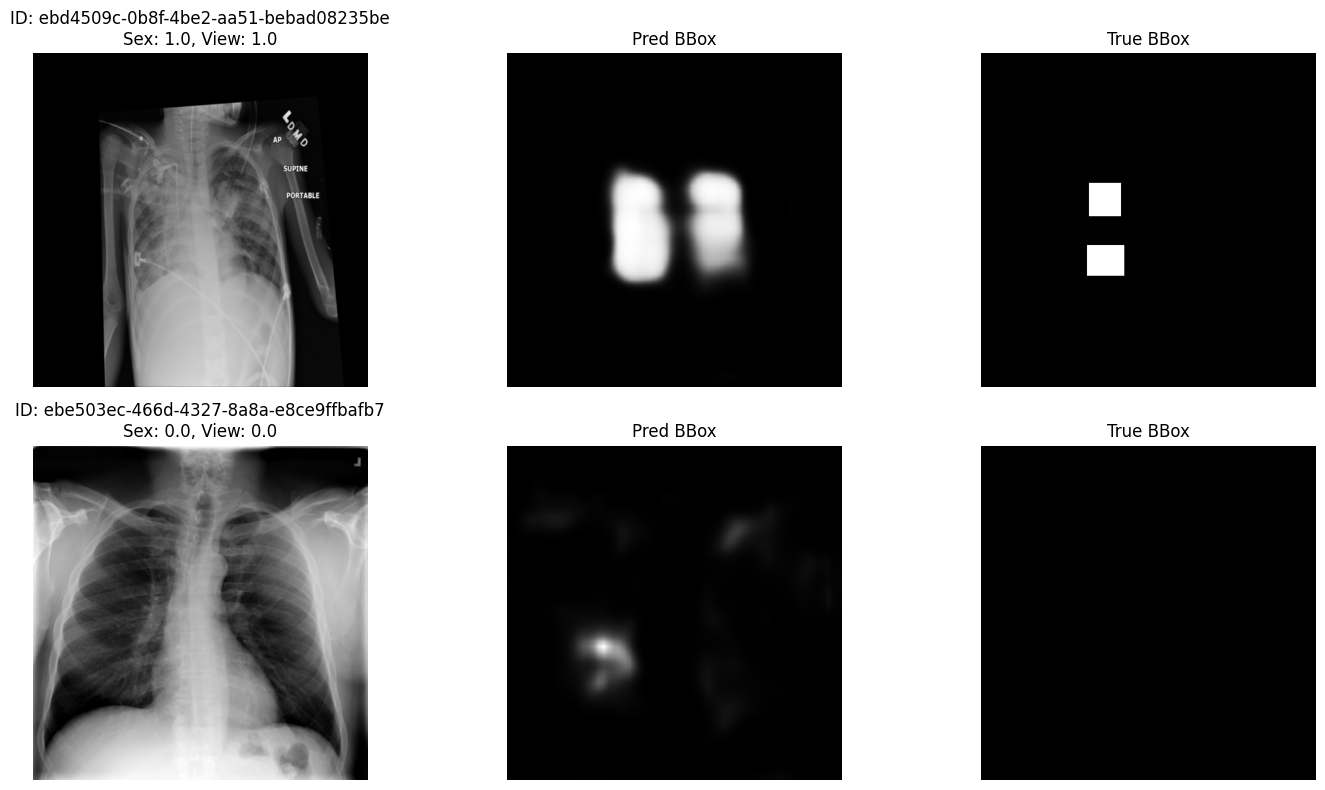

In [60]:
visualize_sample_pair3(model3, test_loader2, device)

In [28]:
# Help function to plot sensitivity and specificity for different prediction threshold values for the probability
# And return best threshold for Youden index
def plot_sensitivity_specificity_curve(y_true, y_probs):
    thresholds = np.linspace(0, 1, 100)
    sensitivities = []
    specificities = []
    youdens = []

    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2,2):
            tn, fp, fn, tp = cm.ravel()

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            sensitivities.append(sensitivity)
            specificities.append(specificity)
            youdens.append(sensitivity + specificity - 1)
        else:
            sensitivities.append(0)
            specificities.append(0)
            youdens.append(-1)  # bad index if confusion matrix isn't 2x2

    sensitivities = np.array(sensitivities)
    specificities = np.array(specificities)
    youdens = np.array(youdens)

    # Find best threshold
    best_idx = np.argmax(youdens)
    best_sensitivity = sensitivities[best_idx]
    best_specificity = specificities[best_idx]
    best_threshold = thresholds[best_idx]

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(specificities, sensitivities, marker='o', label='Sensitivity vs Specificity Curve')
    plt.scatter(best_specificity, best_sensitivity, color='red', s=100, label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity vs Specificity Curve with Best Point')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Best Threshold: {best_threshold:.3f}")
    print(f"Sensitivity at best threshold: {best_sensitivity:.3f}")
    print(f"Specificity at best threshold: {best_specificity:.3f}")
    return(best_threshold)

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

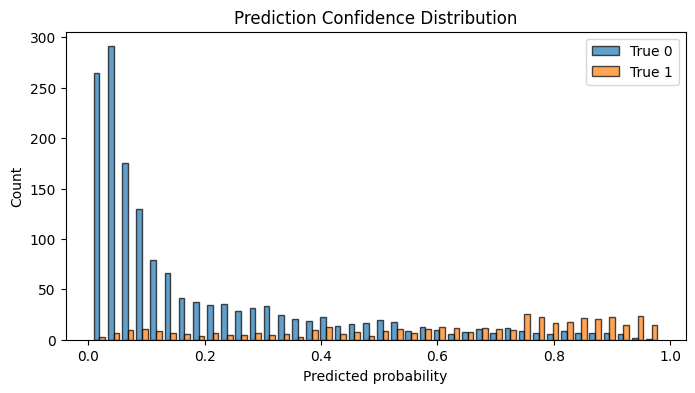

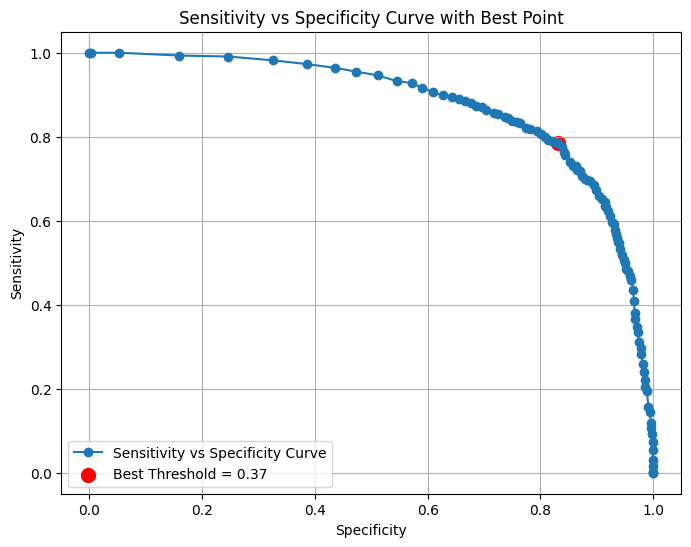

Best Threshold: 0.374
Sensitivity at best threshold: 0.786
Specificity at best threshold: 0.832


In [61]:
# This code visualizes ( for validation data) probability distribution, sensitivity vs specificity curve and generates the best
# probability threshold for pneumonia prediction according to Youden index, saved in best_thresh

# Find all probabilities and true labels for samples in validation loder
with torch.no_grad():
    all_trues = []
    all_preds = []
    all_probs = []
    correct_labels = 0
    total_labels = 0
    bbox_l = 0
    label_l = 0
    val_loss = 0
    
    for imgs, masks, labels, gender, viewpos in tqdm(val_loader2, desc='Validation'):
        imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)

        _, label_pred = model3(imgs, gender, viewpos)
        
        # accuracy
        probs = torch.sigmoid(label_pred.squeeze(-1))        
        all_trues.extend(labels.to('cpu').tolist())
        all_probs.extend(probs.to('cpu').tolist())

# Plot probability distribution per class        
all_probs = np.array(all_probs)
all_trues = np.array(all_trues)

# split preds by true label
pos_preds = all_probs[all_trues == 1]
neg_preds = all_probs[all_trues == 0]

plt.figure(figsize=(8,4))
plt.hist([neg_preds, pos_preds],
         bins=40,
         label=['True 0','True 1'],
         alpha=0.7,
         edgecolor='k')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.show()

# Plot and return best threshold value
best_thresh = plot_sensitivity_specificity_curve(all_trues, all_probs)

Test:   0%|          | 0/84 [00:00<?, ?it/s]

BBox loss: 59.6899,  Label loss: 12.6553
  Test Accuracy: 0.7092


<Axes: >

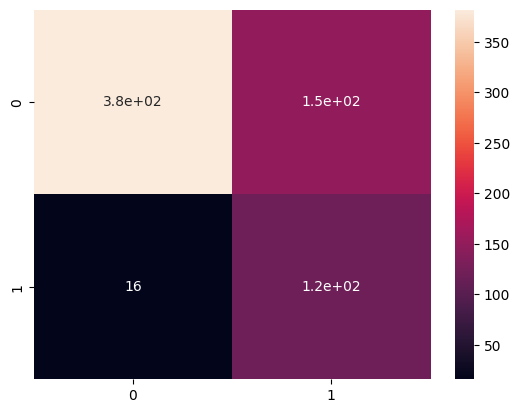

In [196]:
# Create classification report and confusion matrix for test data using the best threshold value best_thresh
with torch.no_grad():
    all_trues = []
    all_preds = []
    all_probs = []
    
    loader = test_loader2
    for imgs, masks, labels, gender, viewpos in tqdm(loader, desc='Test'):
        imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)

        _, label_pred = model3(imgs, gender, viewpos)
       
        # accuracy
        probs = torch.sigmoid(label_pred.squeeze(-1))
        preds = (probs >= best_thresh).float()
        correct_labels += (preds == labels).sum().item()
        total_labels   += labels.size(0)

        all_trues.extend(labels.to('cpu').tolist())
        all_preds.extend(preds.to('cpu').tolist())
        all_probs.extend(probs.to('cpu').tolist())

print(f"  Test Accuracy: {val_acc:.4f}")
cf_matrix = confusion_matrix(all_trues, all_preds)
sns.heatmap(cf_matrix, annot=True)

 # Classification Report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(all_trues, all_preds, digits=4))


  0%|          | 0/84 [00:00<?, ?it/s]

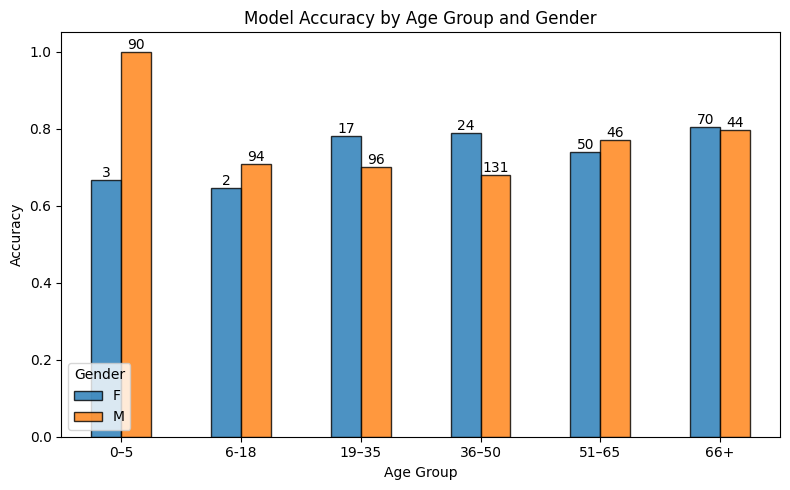

In [179]:
# Bin ages

model = model3
ids = test_ids2
set_ids = False # If you want to compare between models, True lets you set the patient ids to load into a new test_loader



if set_ids:
    # Create dataset with desired åatient IDs
    test_df3  = labels_df2[labels_df2["patientId"].isin(test_ids)].reset_index(drop=True)
    #Instantiate the dataset
    test_ds3  = PneumoniaDataset3(test_df3,  IMAGES_DIR, lung_mask_dir=LUNG_MASK_DIR, bbox_mask_dir=BBOX_MASK_DIR, augment = False)
    test_loader3  = DataLoader(test_ds3,  batch_size=8, shuffle=False, num_workers=4)
    loader = test_loader3
else:
    loader = test_loader2 # our standard test_loader

all_preds, all_trues = [], []
with torch.no_grad():
    for imgs, _, labels,gender, viewpos in tqdm(loader):
        imgs, gender, viewpos = imgs.to(device),  gender.to(device), viewpos.to(device) 
        _,logits= model3(imgs.to(device), gender, viewpos)
        probs  = torch.sigmoid(logits).cpu()
        preds = (probs >= best_thresh)
        all_preds.extend(preds.to('cpu').tolist())
        all_trues.extend(labels.to('cpu').tolist())
        correct_labels += (preds == labels).sum().item()
        total_labels   += labels.size(0)

df_full_val   = df_full[df_full["patientId"].isin(ids)].reset_index(drop=True)

# create a new dataframe that contains predictions and true labels
metadata_df = df_full_val.copy()
metadata_df['pred'] = all_preds
metadata_df['true'] = all_trues
# Create desired age groups
metadata_df['age_group'] = pd.cut(
    metadata_df.PatientAge,
    bins=[0,5 , 18, 35, 50, 65, 120],
    labels=['0–5', '6-18', '19–35', '36–50', '51–65', '66+']
)

# Compute “correct” flag and store in new column
metadata_df['correct'] = (metadata_df.pred == metadata_df.true).astype(int)

# Group by both age_group and gender, then pivot
acc_table = (
    metadata_df
    .groupby(['age_group', 'PatientSex'])
    .correct
    .mean()
    .unstack('PatientSex')    # puts each gender into its own column
)

# Compute counts table
counts_table = (
    metadata_df.groupby(['age_group', 'PatientSex'])
    .size()
    .unstack('PatientSex')
)


# 5. Plot a grouped bar chart
ax = acc_table.plot(
    kind='bar',
    figsize=(8,5),
    edgecolor='k',
    alpha=0.8
)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Age Group")
ax.set_title("Model Accuracy by Age Group and Gender")
ax.legend(title="Gender", loc = 'lower left')
plt.xticks(rotation=0)

# 7. Annotate counts on each bar
#    We flatten counts_table in the same order as the bars are drawn:
counts = counts_table.values.flatten(order='C')
for patch, count in zip(ax.patches, counts):
    # x = center of bar, y = top of bar
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_height()
    ax.text(x, y, str(count), ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

0.002213542 0.9999256
0.0108455885 0.9964461
0.0058170995 0.9847132
0.0 0.99022776
0.0 0.9917892
0.0 0.992507
0.0018513034 0.9754887
0.0 0.98253673
0.0 0.9911765
0.0 0.98611116
0.0011954573 0.96829236
0.019459708 0.9625401
0.0011642157 0.9865809
0.0 0.8873775
0.0 0.99221814
0.0 0.81311274
0.0 0.9925245
0.001590155 0.9625277
0.0 0.9436063
0.011699507 0.9647764


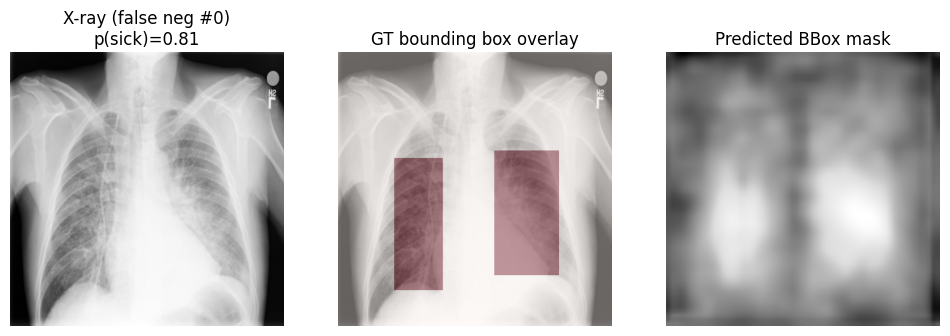

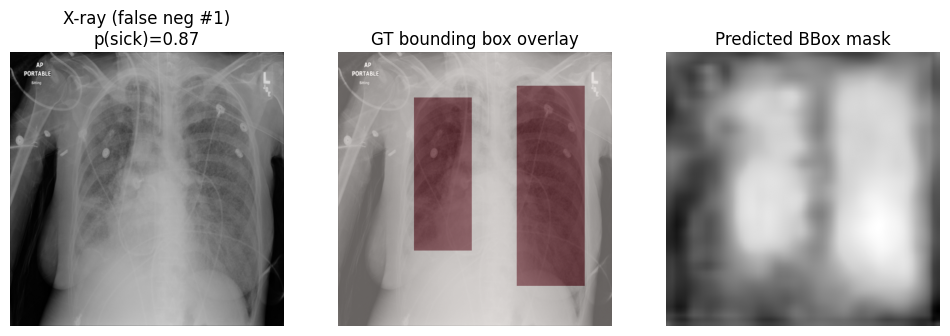

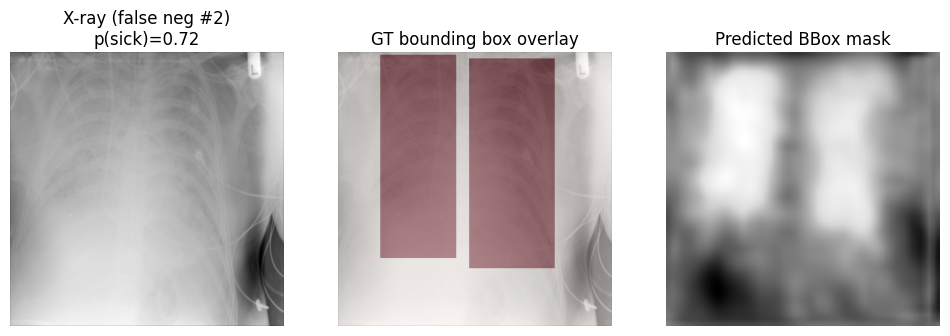

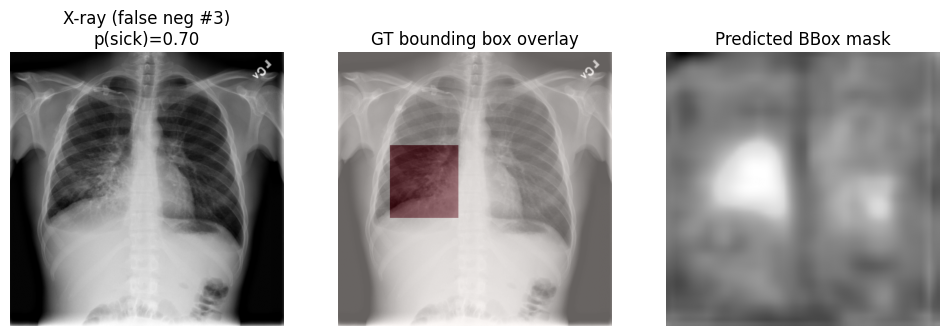

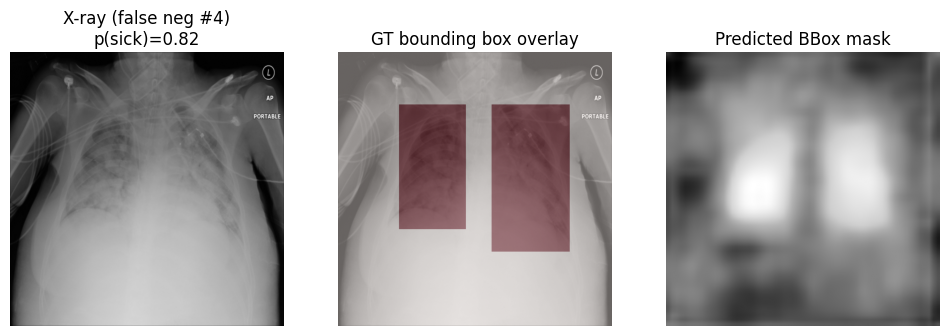

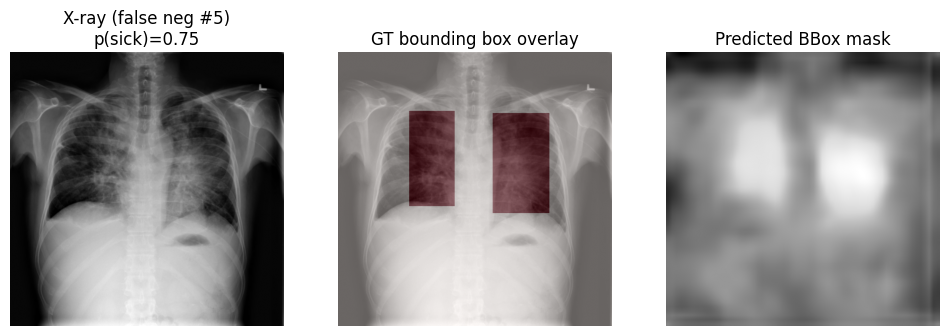

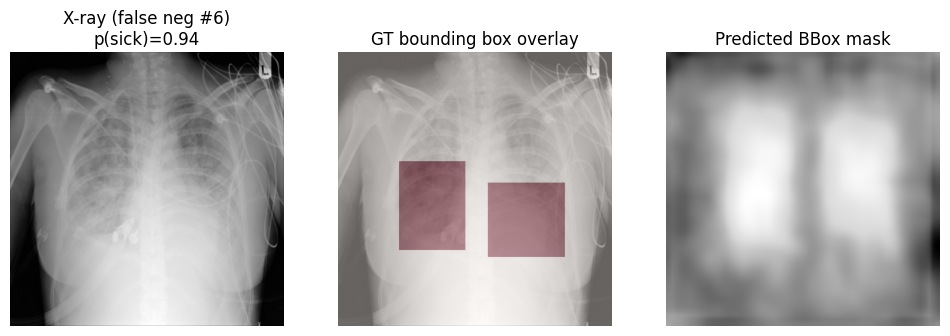

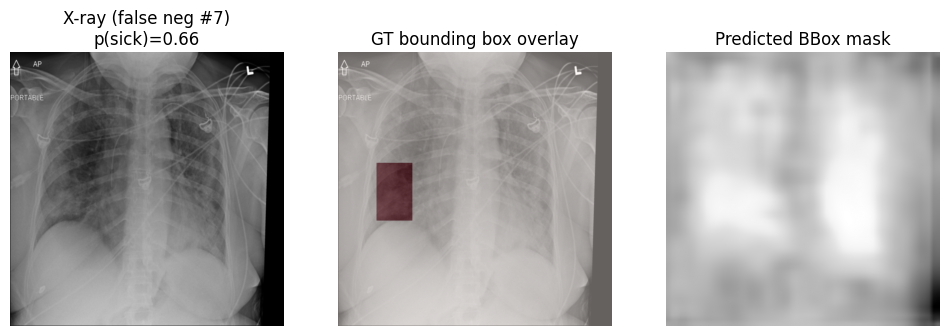

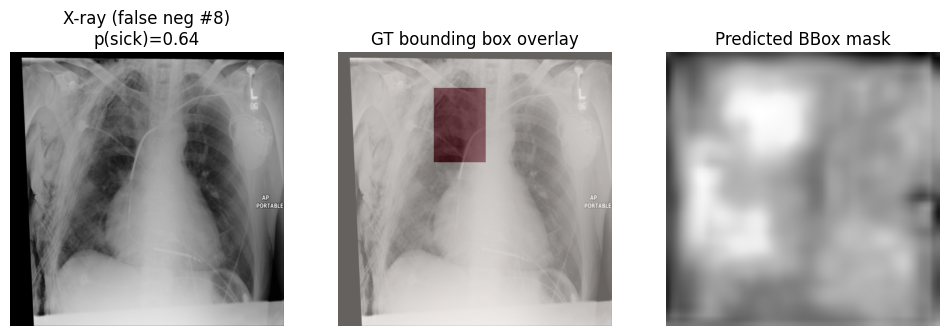

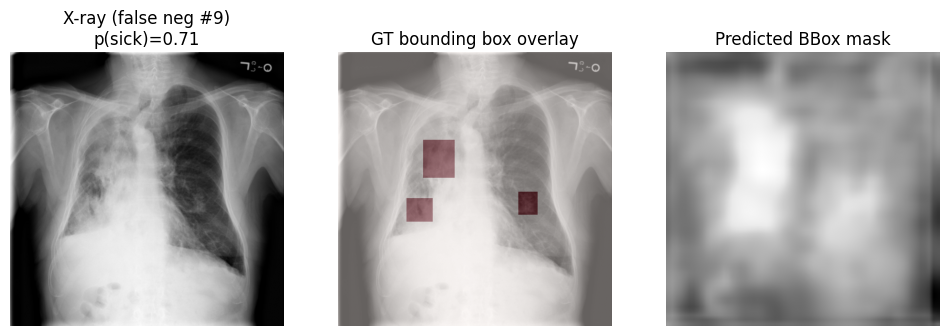

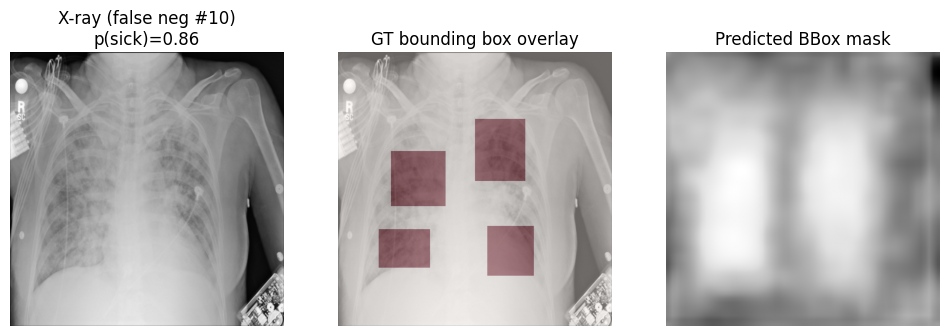

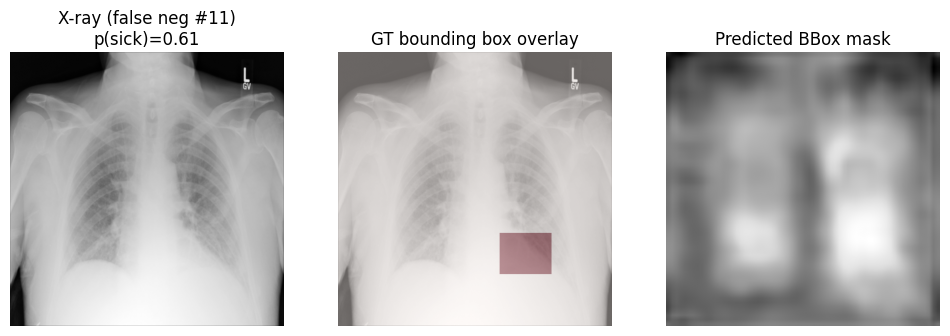

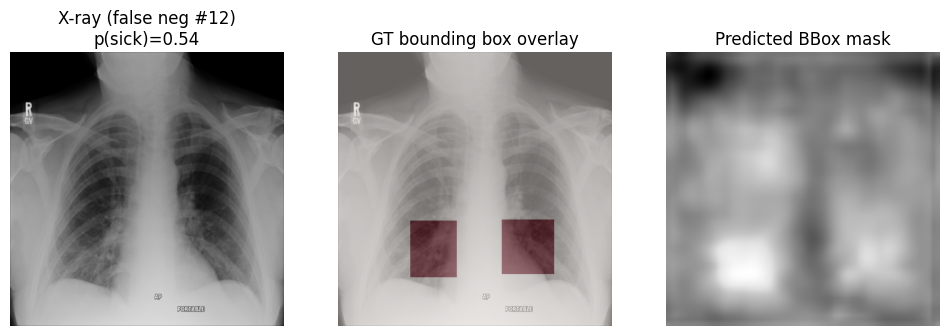

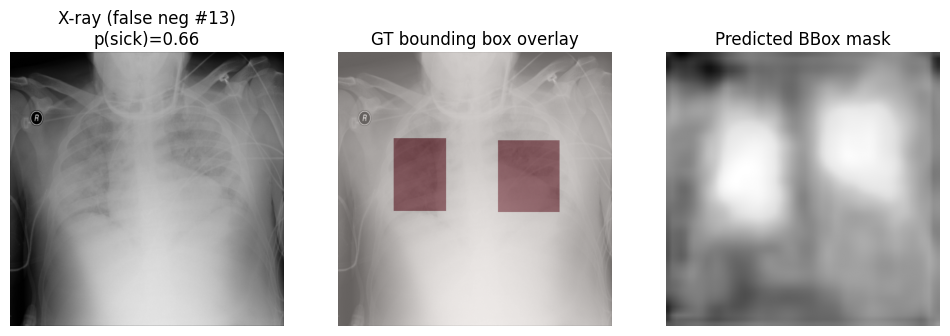

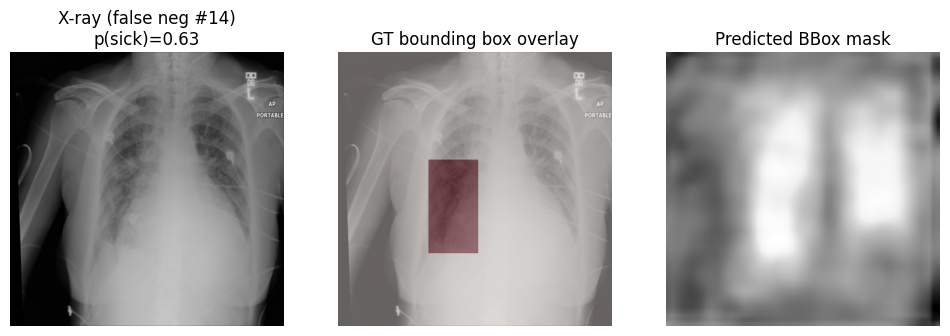

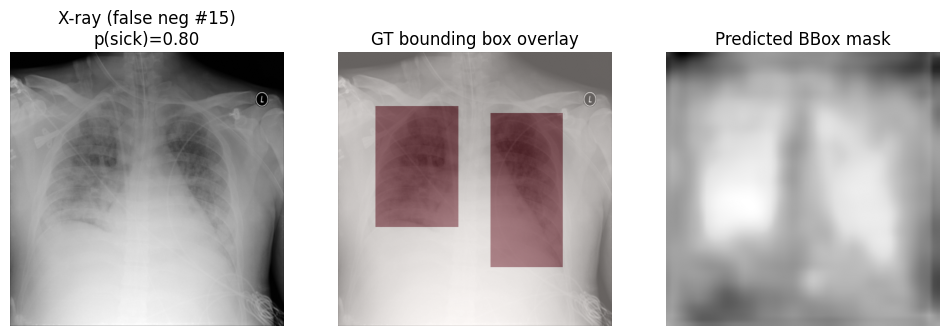

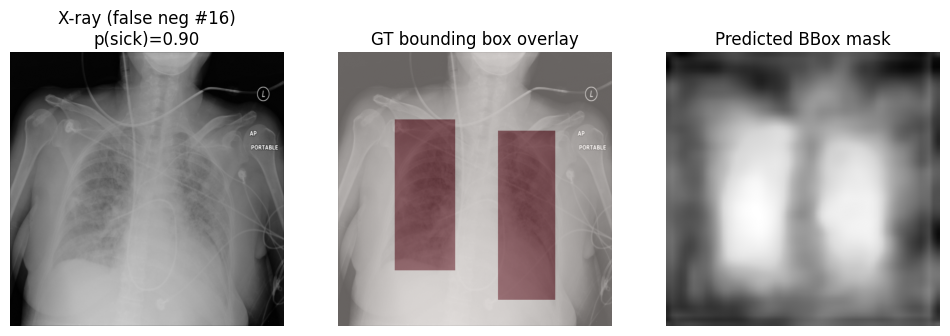

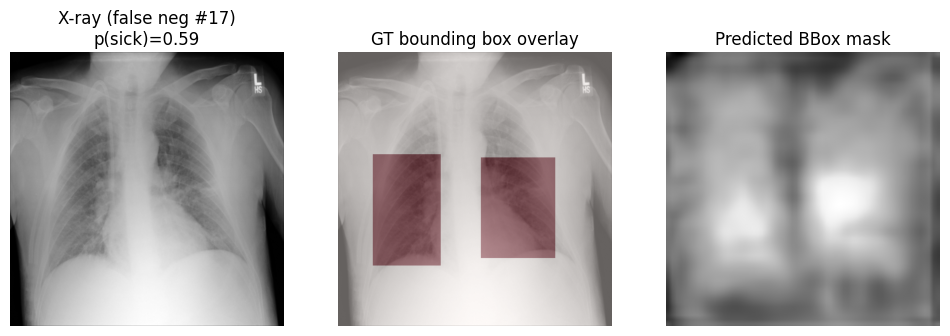

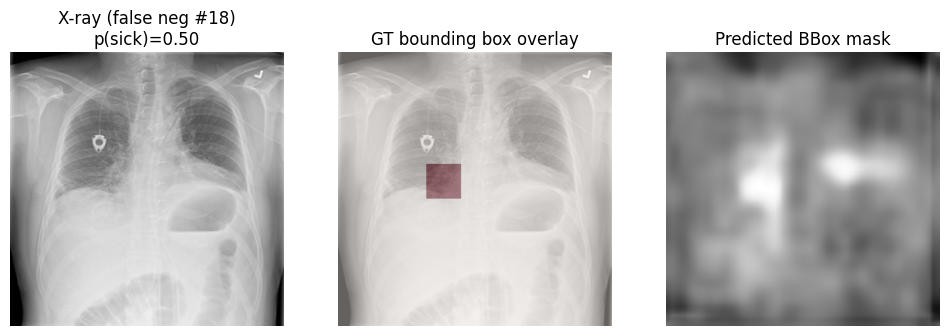

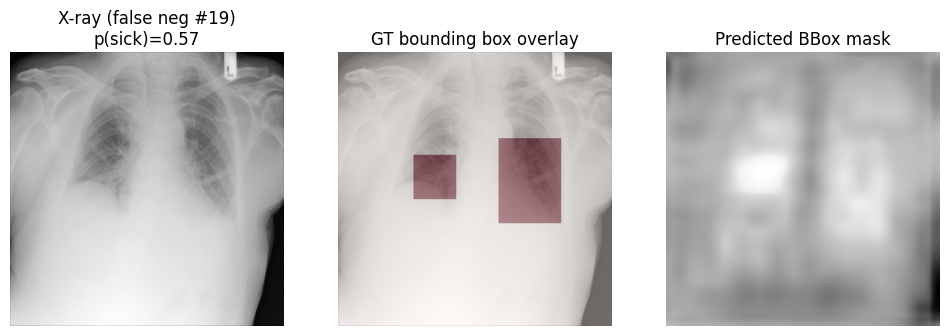

In [19]:
import torch
import matplotlib.pyplot as plt

def show_mislabelled_pneumonia(loader, model, device, num_examples=5):
    """
    Find up to num_examples cases where label=1 (pneumonia) but pred=0 (healthy),
    then plot: [X-ray | GT BBox mask | classifier p(sick)].
    """
    model.eval()
    mis = []

    with torch.no_grad():
        for imgs, masks, labels, gender, viewpos in loader:
            imgs, masks, labels, gender, viewpos = imgs.to(device), masks.to(device), labels.to(device), gender.to(device), viewpos.to(device)
            
            pred_masks, logits = model(imgs, gender, viewpos)
            probs = torch.sigmoid(logits.squeeze(-1))
            preds = (probs >= 0.414).long()

            # mask of false negatives
            fn_mask = (labels == 1) & (preds == 1)
            for i in fn_mask.nonzero(as_tuple=False).flatten():
                mis.append({
                    'img':   imgs[i].cpu(), 
                    'bbox':  masks[i,1].cpu(),
                    'prob':  probs[i].item(),
                    'pred_bbox': pred_masks[i,1,:,:].cpu(),
                    'pred_lung': pred_masks[i,0,:,:].cpu()
                })
                if len(mis) >= num_examples:
                    break
            if len(mis) >= num_examples:
                break

    # Plot each
    for idx, ex in enumerate(mis):
        img   = ex['img'].squeeze(0).numpy()      # (H,W)
        
        img = np.transpose(img, (1,2,0))
        arr = img[:,:,0]
        #arr = (arr - arr.min())/arr.max()
        print(arr.min(),arr.max())
        bbox  = ex['bbox'].numpy()                # (H,W)
        prob  = ex['prob']
        bbox_mask = ex['pred_bbox']
        lung_mask = ex['pred_lung']
        fig, axes = plt.subplots(1, 3, figsize=(12,4))
        axes[0].imshow(arr, cmap = 'gray')
        axes[0].set_title(f"X-ray (false neg #{idx})\np(sick)={prob:.2f}")
        axes[0].axis('off')

        
        axes[1].imshow(arr, cmap='gray')
        axes[1].imshow(bbox, cmap='Reds', alpha=0.4)
        axes[1].set_title(f"GT bounding box overlay")
        axes[1].axis('off')

        axes[2].imshow(bbox_mask, cmap='gray')
        axes[2].set_title("Predicted BBox mask")
        axes[2].axis('off')

        

# Usage:
show_mislabelled_pneumonia(test_loader2, model3, device, num_examples=20)

In [69]:
import torch
import matplotlib.pyplot as plt

def visualize_film_effect(model, img, gender, viewpos, true_mask, device):
    """
    Compare segmentation & classification with vs. without FiLM (γ only).
    
    model:      your FiLM‐conditioned LungBBoxAndClassifierModel
    img:        Tensor (1,3,512,512), on `device`
    gender:     Tensor (1,), 0/1 on `device`
    viewpos:    Tensor (1,), 0/1 on `device`
    true_mask:  Tensor (2,512,512) un‐sigmoided ground truth mask
    """
    model.eval()
    img = img.to(device)
    gender = gender.to(device)
    viewpos = viewpos.to(device)
    with torch.no_grad():
        # 1) encode
        feats = model.encoder(img)            # → (1,2048,H',W')
        
        # 2) compute FiLM γ
        meta   = torch.stack([gender.float(), viewpos.float()], dim=1)  # (1,2)
        logits = model.film_gen(meta)         # (1,2048)
        attn   = torch.softmax(logits, dim=1) # (1,2048)
        γ      = attn.view(1,2048,1,1) * feats.size(1)  # scale by channel count
        
        # 3a) raw outputs
        seg_raw = torch.sigmoid(model.decoder(feats))[0,1].cpu().numpy()
        cls_raw = torch.sigmoid(model.classifier(feats).squeeze(1))[0].item()
        
        # 3b) FiLM‐modulated outputs
        feats_mod = feats * γ
        seg_mod   = torch.sigmoid(model.decoder(feats_mod))[0,1].cpu().numpy()
        cls_mod   = torch.sigmoid(model.classifier(feats_mod).squeeze(1))[0].item()
    
    # 4) grab true bbox
    true_bbox = true_mask[1].cpu().numpy()
    
    # 5) plot
    fig, axs = plt.subplots(1,5,figsize=(20,5))
    # X-ray
    x = img.cpu()[0,0]
    axs[0].imshow(x, cmap='gray');   axs[0].set_title("X-ray");      axs[0].axis('off')
    # raw vs modulated BBox
    axs[1].imshow(seg_raw, cmap='gray');   axs[1].set_title("Raw BBox");   axs[1].axis('off')
    axs[2].imshow(seg_mod, cmap='gray');   axs[2].set_title("FiLM BBox");  axs[2].axis('off')
    # difference
    diff = seg_mod - seg_raw
    im   = axs[3].imshow(diff, cmap='bwr', vmin=-diff.max(), vmax=diff.max())
    axs[3].set_title("Δ (FiLM−raw)"); axs[3].axis('off')
    fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)
    # true
    axs[4].imshow(true_bbox, cmap='gray')
    axs[4].set_title("True BBox");  axs[4].axis('off')
    plt.tight_layout()
    plt.show()
    
    # 6) print class probs
    print(f"Label prob raw = {cls_raw:.3f},  with FiLM = {cls_mod:.3f}")
    print(f"Gender = {int(gender.item())}, viewpos = {int(viewpos.item())}")

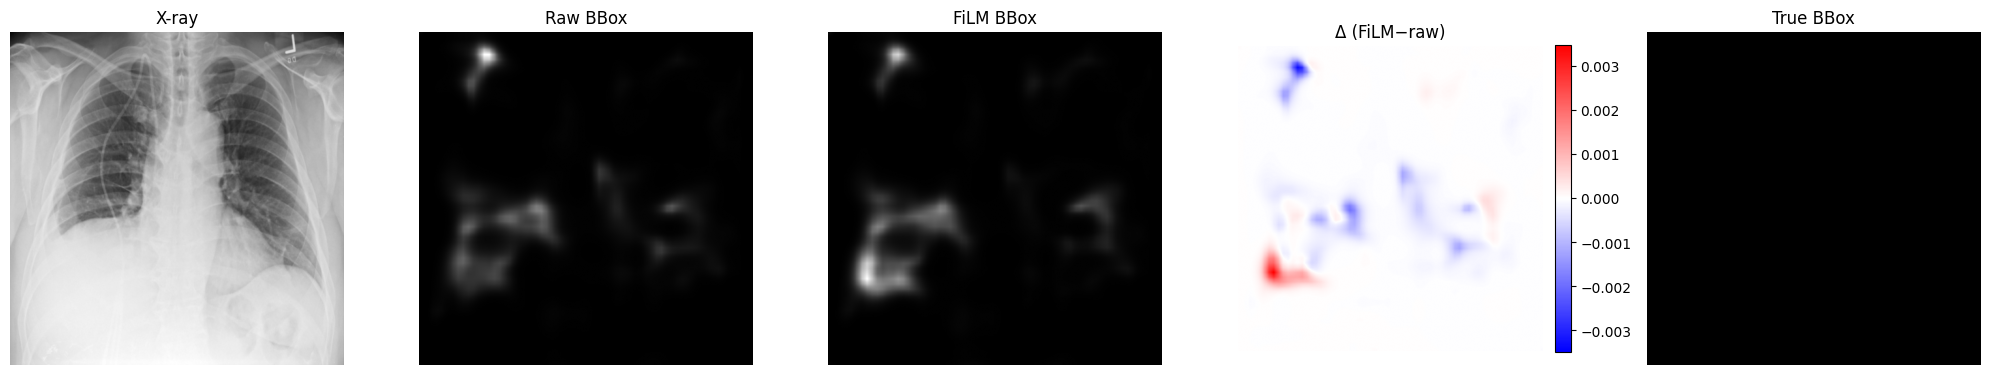

Label prob raw = 0.099,  with FiLM = 0.106
Gender = 0, viewpos = 0


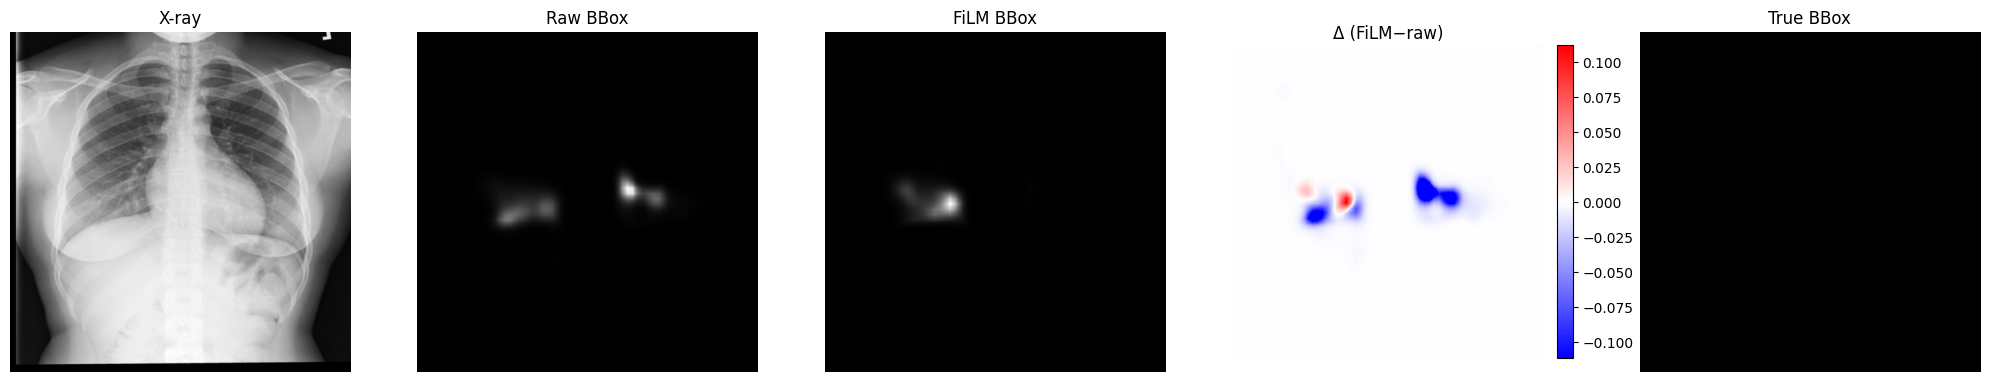

Label prob raw = 0.130,  with FiLM = 0.170
Gender = 1, viewpos = 0


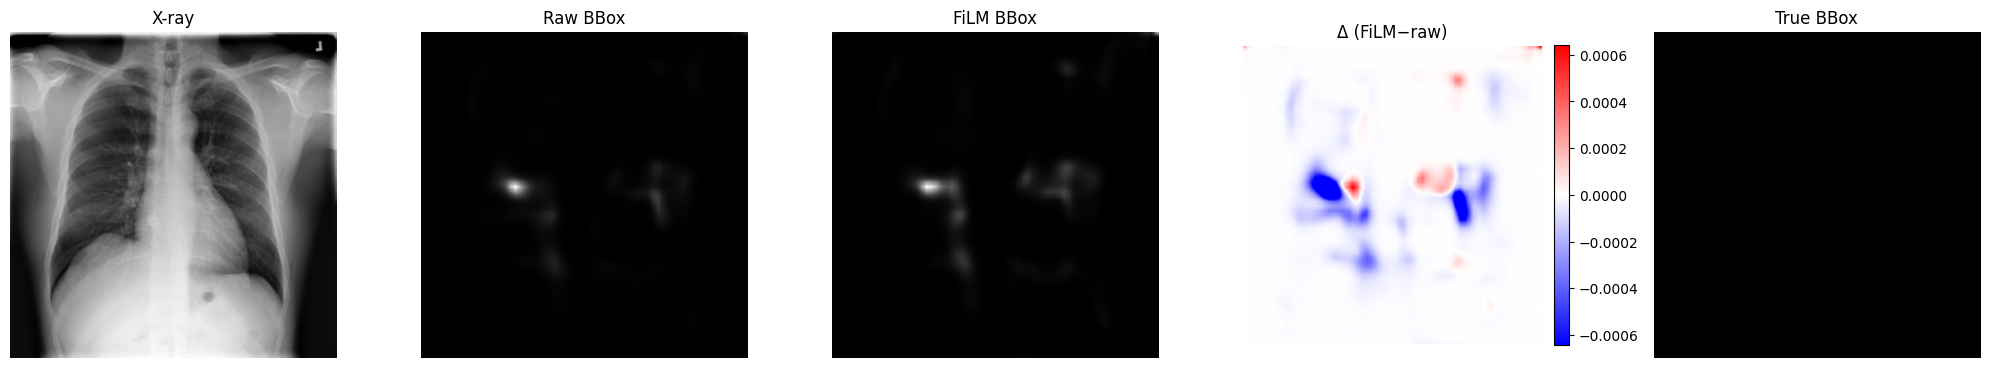

Label prob raw = 0.074,  with FiLM = 0.075
Gender = 0, viewpos = 0


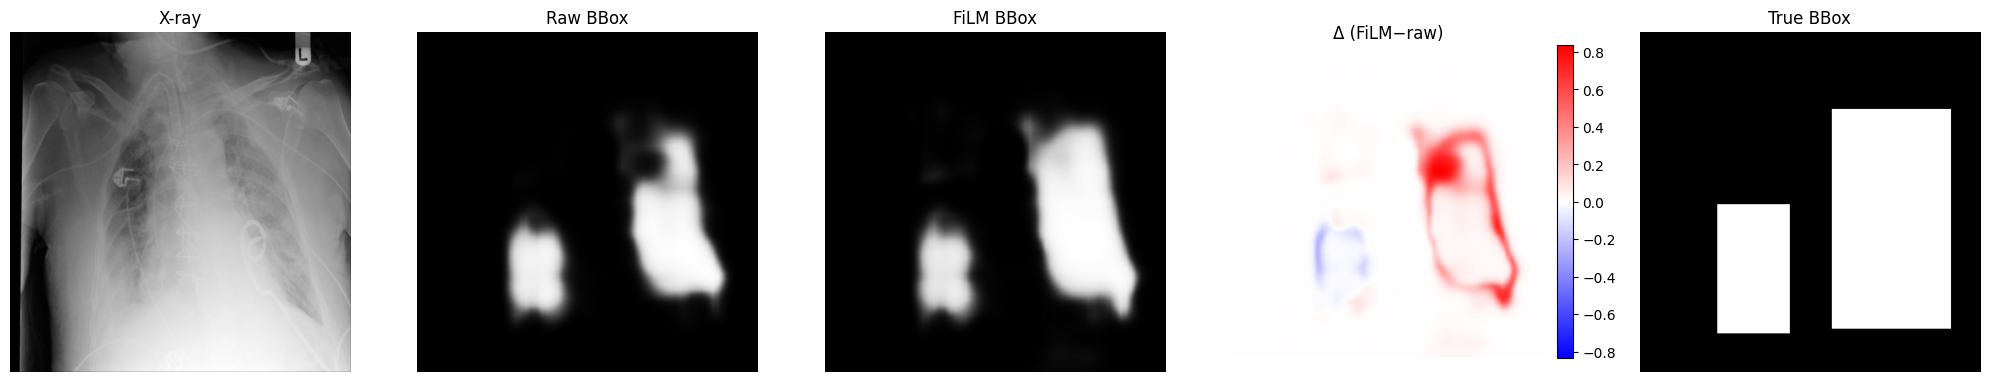

Label prob raw = 0.513,  with FiLM = 0.633
Gender = 0, viewpos = 1


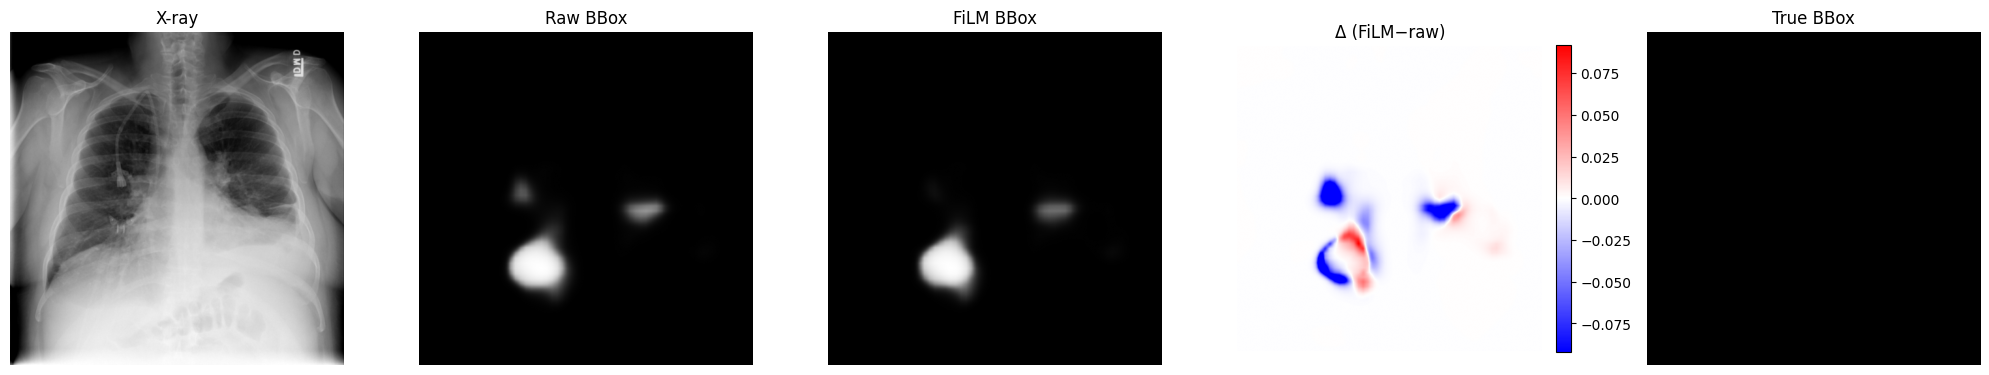

Label prob raw = 0.273,  with FiLM = 0.358
Gender = 0, viewpos = 0


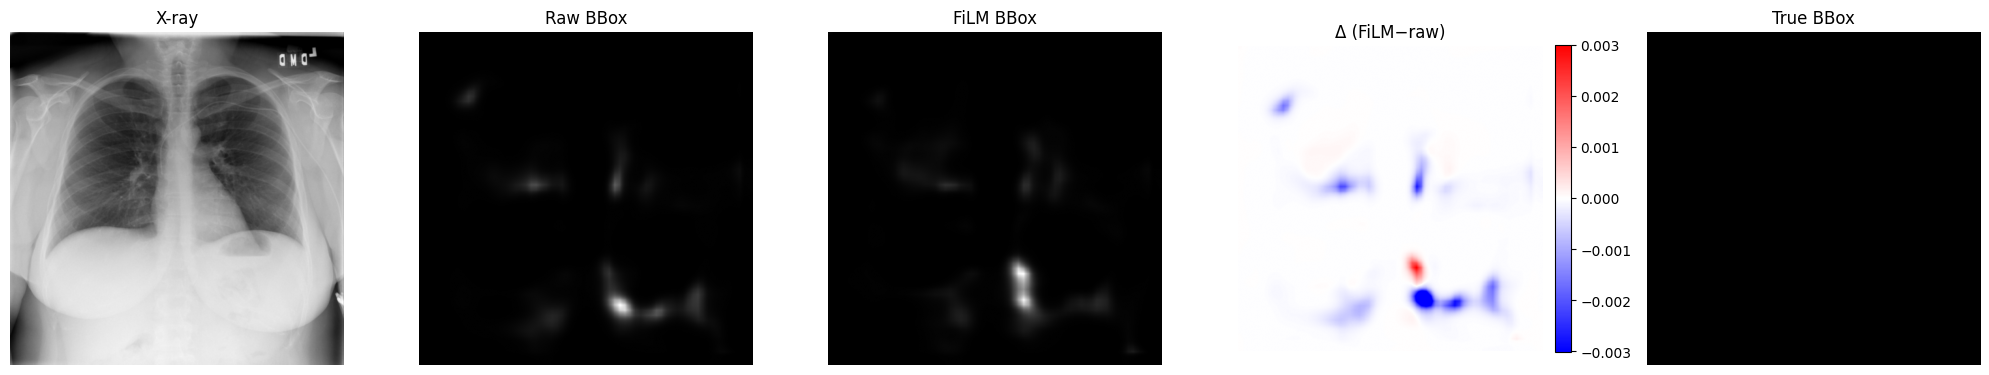

Label prob raw = 0.044,  with FiLM = 0.054
Gender = 1, viewpos = 0


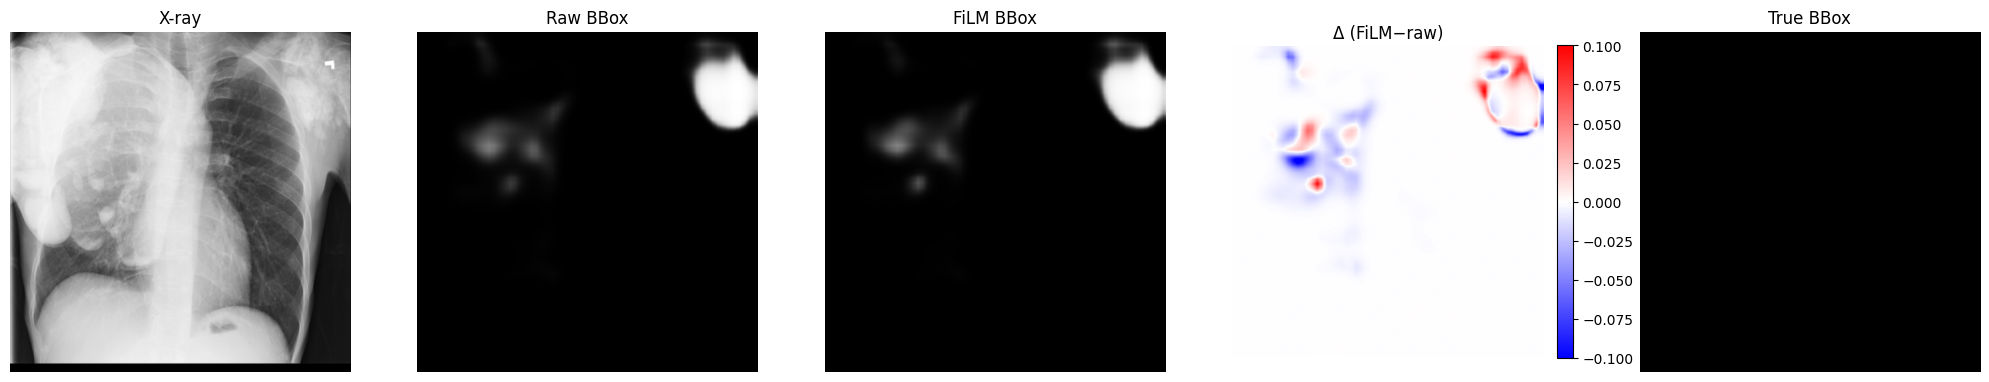

Label prob raw = 0.378,  with FiLM = 0.526
Gender = 0, viewpos = 0


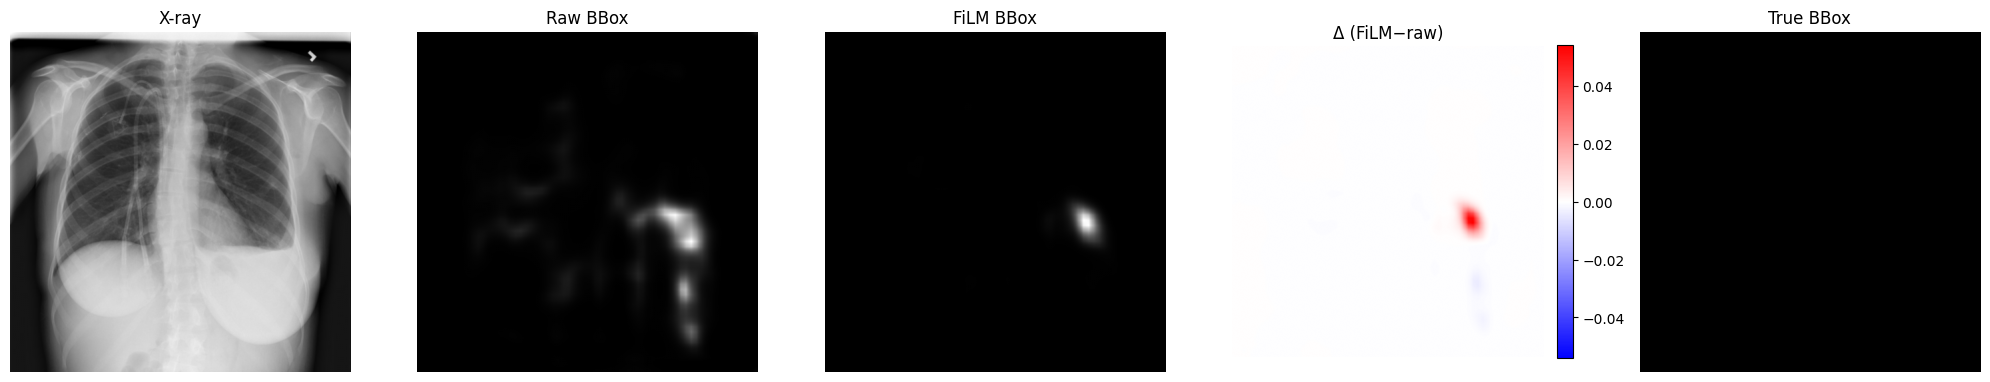

Label prob raw = 0.105,  with FiLM = 0.125
Gender = 1, viewpos = 0


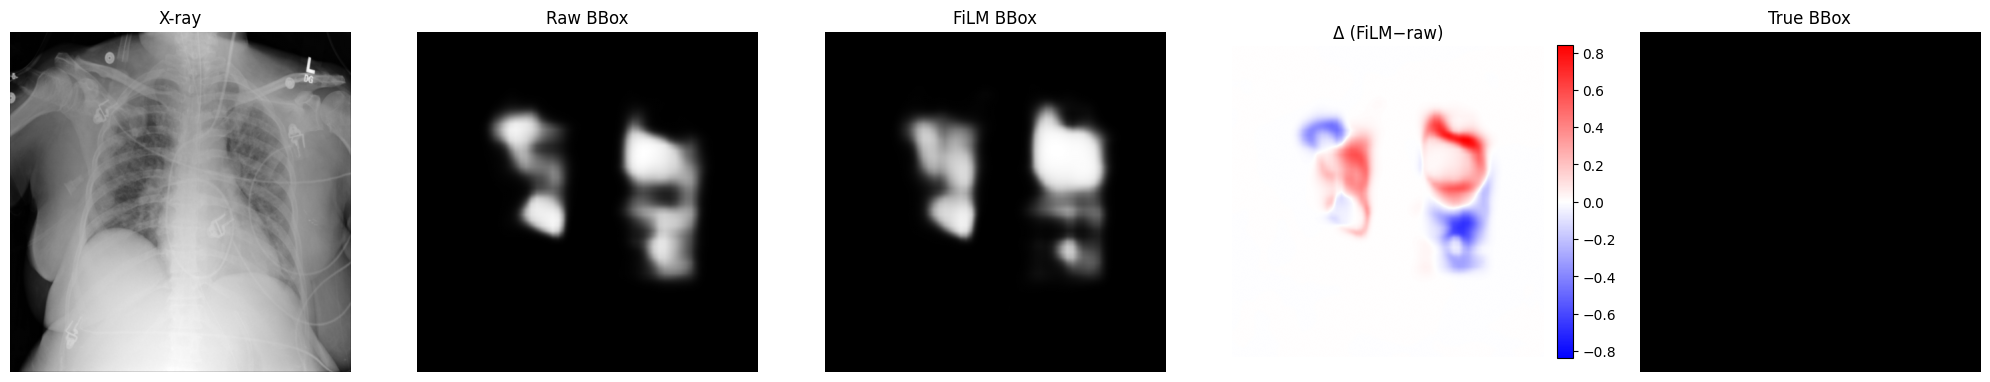

Label prob raw = 0.479,  with FiLM = 0.638
Gender = 1, viewpos = 1


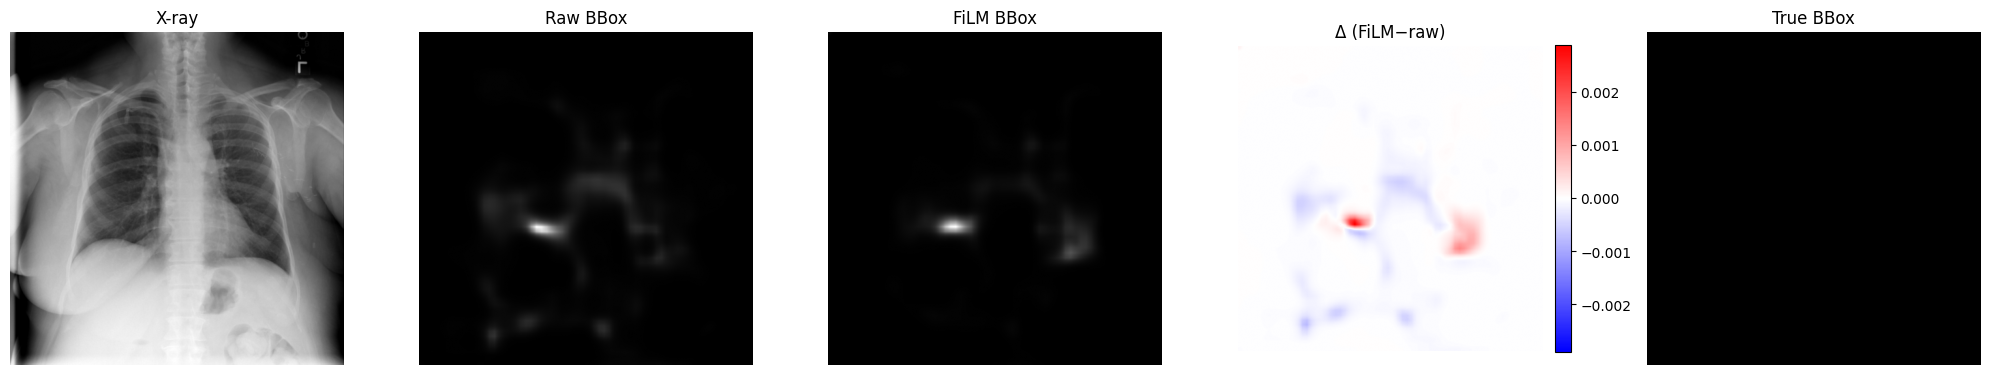

Label prob raw = 0.098,  with FiLM = 0.128
Gender = 1, viewpos = 0


In [79]:
# take one sample
im_no = 4
no_of_ims = 10
ex_id = 1
for imgs, masks, labels, gender, viewpos in val_loader2:
    #next(iter(val_loader2))
    img0       = imgs[im_no:im_no+1].to(device)
    g0         = gender[im_no:im_no+1].to(device)
    v0         = viewpos[im_no:im_no + 1].to(device)
    label0 = labels[im_no:im_no+1].to(device)
    
    mask0 = masks[im_no, :, :]
    visualize_film_effect(model3, img0, g0, v0, mask0, device)
    ex_id += 1
    if ex_id > no_of_ims:
        break

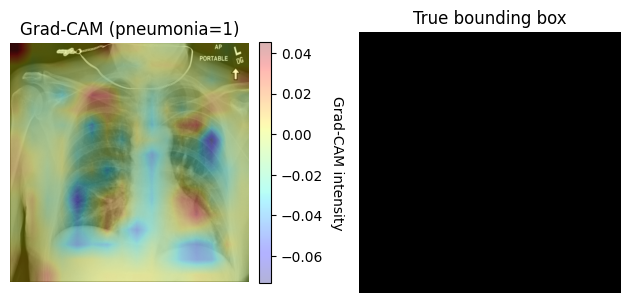

In [135]:
import torch
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam, LayerAttribution

# 1) Prep
model3.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
im_no = 5
# Grab one example from val_loader:
imgs, masks, labels, genders, viewposes = next(iter(val_loader2))
mask = masks[im_no:im_no+1, 1, :,:].cpu().numpy().squeeze()
img_tensor = imgs[im_no:im_no+1].to(device)               # (1,3,512,512)
gen = genders[im_no:im_no+1].to(device)        # (1,)
vp  = viewposes[im_no:im_no+1].to(device)      # (1,)
img_tensor.requires_grad_()                     # needed for captum



# 1) pick the layer you want to hook (e.g. the last conv in your encoder)
target_layer = model3.encoder[-1]

# 2) make a tiny wrapper that accepts (img, gender, viewpos)
#    and returns *only* the 1-D class score tensor
def forward_for_cam(x, gender, viewpos):
    # logit from the model
    _, cls_logit = model3(x, gender, viewpos)
    return cls_logit

# 3) build the LayerGradCam explainer on that wrapper
cam = LayerGradCam(forward_for_cam, target_layer)

# 4) now call attribute with your image + meta as extra args
img   = img_tensor.to(device)    # (1,3,512,512)


# assuming you want class “1” (pneumonia)
attributions = cam.attribute(
    img,
    additional_forward_args=(gen, vp)
)
upsampled_attr = F.interpolate(
    attributions,
    size=img_tensor.shape[2:],      # (512,512)
    mode="bilinear",
    align_corners=False
)

# now collapse the channel dimension:
heatmap = upsampled_attr[0].mean(dim=0).cpu().detach().numpy()
# 6) We then collapse the channel dim by summing or averaging:
#heatmap = attributions[0].mean(dim=0).cpu().detach().numpy()
'''
heatmap -= heatmap.min()
if heatmap.max() > 0:
    heatmap /= heatmap.max()
print(heatmap.size)
'''
# 7) Overlay on the original
orig = img[0].detach().cpu().numpy().transpose(1,2,0)[...,0]  # (512,512), grayscale
fig, axs = plt.subplots(1,2)
axs[0].imshow(orig, cmap='gray')
cam_im = axs[0].imshow(heatmap, cmap='jet', alpha=0.3)  # α controls transparency
# add colorbar for the heatmap

cbar = plt.colorbar(
    cam_im,            # ← make sure this is the heatmap artist
    ax=axs[0],             # draw it next to our axes
    fraction=0.046,    # adjust size
    pad=0.04           # adjust padding
)
cbar.set_label("Grad-CAM intensity", rotation=270, labelpad=15)
axs[1].imshow(mask, cmap = 'gray')
axs[0].set_title("Grad-CAM (pneumonia=1)")
axs[1].set_title('True bounding box')
axs[0].axis('off')
axs[1].axis('off')
plt.tight_layout()
plt.show()

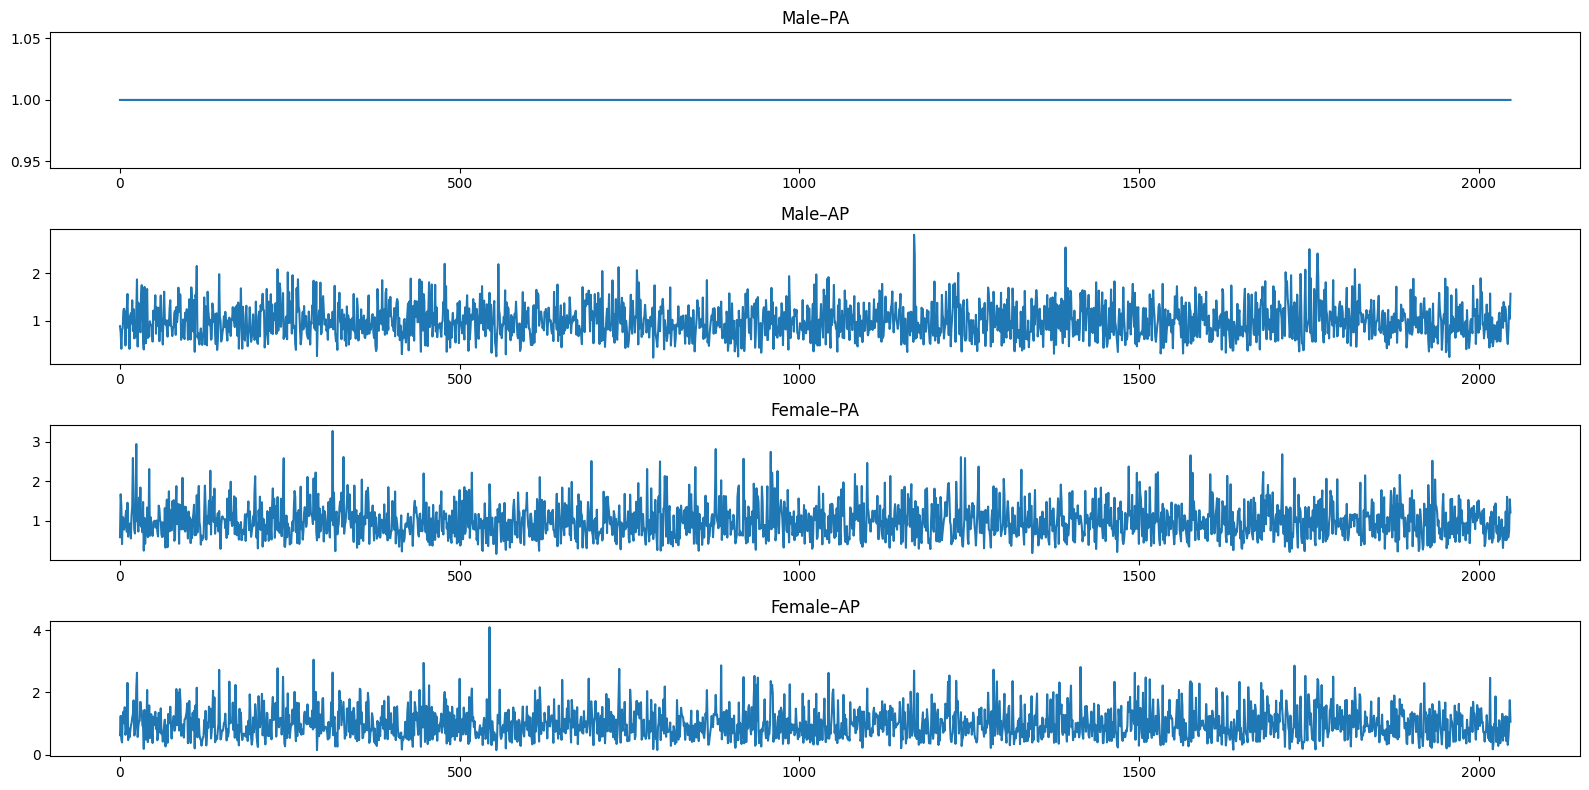

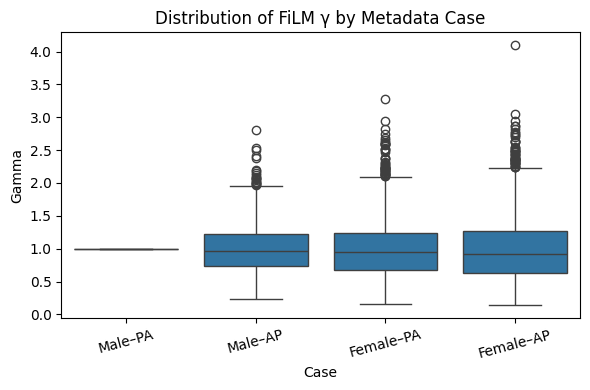

In [43]:
# Load the saved film_gen state dict
torch.save(model3.film_gen.state_dict(), 'film_gen.pth')
state = torch.load('film_gen.pth', map_location='cpu')

# 2) Rebuild the two-layer MLP by hand
W1 = state['0.weight']   # shape (128, 2)

W2 = state['2.weight']   # shape (2048, 128)


def compute_gamma(gender, viewpos):
    x = torch.tensor([gender, viewpos], dtype=torch.float32)  # (2,)
    h = torch.relu(W1 @ x)                               # (128,)
    logits = W2 @ h                                     # (2048,)
    attn = torch.softmax(logits, dim=0)                       # (2048,)
    gamma = attn * logits.numel()                             # scale by 2048
    return gamma.numpy()                                      # (2048,)

# 3) Define your four metadata cases
cases = [
    (0.0, 0.0, 'Male–PA'),
    (0.0, 1.0, 'Male–AP'),
    (1.0, 0.0, 'Female–PA'),
    (1.0, 1.0, 'Female–AP'),
]
gammas={}
# 4) Compute and plot
figure,axs = plt.subplots(4,1, figsize = (16,8))

for num, (g,v,label) in enumerate(cases):
    gamma = compute_gamma(g, v)
    axs[num].plot(gamma, label=label)
    axs[num].set_title(label)
    gammas[label] = gamma
plt.tight_layout()
plt.show()
'''
plt.xlabel('Feature Channel Index')
plt.ylabel('Gamma Value')
plt.title('FiLM Gamma Vectors for Metadata Combinations')
plt.legend()
plt.tight_layout()
plt.show()
'''
# assume `gammas` dict from before
# Flatten into a DataFrame
rows = []
for label, gamma in gammas.items():
    for val in gamma:
        rows.append({'Case': label, 'Gamma': val})
df = pd.DataFrame(rows)

plt.figure(figsize=(6,4))
sns.boxplot(x='Case', y='Gamma', data=df)
plt.xticks(rotation=15)
plt.title('Distribution of FiLM γ by Metadata Case')
plt.tight_layout()
plt.show()